<a href="https://colab.research.google.com/github/catalinakarinip/mercadolabroal/blob/main/mercadolaboral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Script 1: Limpieza bases INE

Para actualizar las bases limpias se debe
1. Subir las bbdd originales del INE
2. Ver si la base de diccionario "variables_por_base" mantiene las columnas, y por tanto las abreviaturas corresponden
3. Cambiar nombre del archivo al compatible con la base de diccionario

El code se demora 1 min en crear todas las bases limpias!!


In [ ]:
# ================= 0. MONTAR DRIVE =====================================
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ================= 1. LIBRER√çAS Y RUTA ========================================
from pathlib import Path
import pandas as pd
import re

ROOT = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio")
ORIG_DIR = ROOT / "Datos_ENE_originales"
CLEAN_DIR = ROOT / "Datos_ENE_limpios"
CLEAN_DIR.mkdir(parents=True, exist_ok=True)

MAP_FILE = ROOT / "resultados/variables_por_base.xlsx"
MAP_SHEET = 0

# ================= 2. DICCIONARIO DE ABREVIATURAS =====================
def load_abbreviations() -> dict:
    df_map = (
        pd.read_excel(MAP_FILE, sheet_name=MAP_SHEET, usecols="A:C")
        .rename(columns=str.lower)
        .dropna()
    )
    df_map["base"] = (
        df_map["base"].str.strip().str.replace(".xlsx", "", regex=False).str.lower()
    )
    df_map["var_original"] = df_map["var_original"].str.strip()
    df_map["abreviatura"] = df_map["abreviatura"].str.strip()
    return {(r.base, r.var_original): r.abreviatura for r in df_map.itertuples()}

# ================= 4. HOJAS A CONSERVAR ================================
ID_VARS = ["A√±o", "Trimestre"]
HOJAS_OBJETIVO = {
    "AS",
    "AP",
    "TA",
    "AN",
    "AT",
    "CO",
    "VA",
    "RM",
    "LI",
    "ML",
    "NB",
    "BI",
    "AR",
    "LR",
    "LL",
    "AI",
    "MA",
}

# ================= 5. CONVERSI√ìN N√öMEROS LATINOS =======================

LATIN_NUMBER_RE = re.compile(r"^\d{1,3}(\.\d{3})*(,\d+)?$")

def texto_a_numero(valor: str):
    if pd.isna(valor):
        return None
    texto = str(valor)
    if LATIN_NUMBER_RE.match(texto):
        texto = texto.replace(".", "").replace(",", ".")
    else:
        texto = texto.replace(",", ".")
    try:
        return float(texto)
    except ValueError:
        return None

# ================= 6. LIMPIADOR DE HOJAS ===============================
def limpiar_hoja(df: pd.DataFrame, base_alias: str, abbr: dict) -> pd.DataFrame:
    df = df.copy()
    df.columns = df.columns.str.strip()
    columnas_a_borrar = []
    renombres = {}
    columnas = list(df.columns)

    for i, col in enumerate(columnas):
        if col in ID_VARS or "Unnamed" not in col:
            continue
        anterior = columnas[i - 1].strip() if i > 0 else ""
        if anterior in ID_VARS or not anterior:
            columnas_a_borrar.append(col)
            continue
        alias = abbr.get((base_alias, anterior))
        if alias:
            renombres[col] = f"{alias}_{base_alias}"
        else:
            columnas_a_borrar.append(col)

    df = df.drop(columns=columnas_a_borrar, errors="ignore").rename(columns=renombres)
    df = df[df[ID_VARS[0]].notna() | df[ID_VARS[1]].notna()].reset_index(drop=True)

    # Normalize quarter names so they match TRIM_OK in unify_panel.py
    quarter_map = {
        "1": "Ene - Mar",
        "2": "Abr - Jun",
        "3": "Jul - Sep",
        "4": "Oct - Dic",
        "ene-mar": "Ene - Mar",
        "abr-jun": "Abr - Jun",
        "jul-sep": "Jul - Sep",
        "oct-dic": "Oct - Dic",
        "ene - mar": "Ene - Mar",
        "abr - jun": "Abr - Jun",
        "jul - sep": "Jul - Sep",
        "oct - dic": "Oct - Dic",
    }
    df["Trimestre"] = (
        df["Trimestre"].astype(str).str.strip().str.lower().replace(quarter_map)
    )
    df["A√±o"] = pd.to_numeric(df["A√±o"], errors="coerce")

    for col in renombres.values():
        df[col] = df[col].apply(texto_a_numero)

    return df[[*ID_VARS, *renombres.values()]]

# ================= 7. PROCESAR ARCHIVOS =================================
def procesar_archivos():
    abbr = load_abbreviations()
    for src in ORIG_DIR.glob("*.xlsx"):
        base_alias = src.stem.split("_")[0].lower()
        dest = CLEAN_DIR / f"{base_alias}_limpia.xlsx"
        if dest.exists():
            print(f"‚Üª  Reemplazando {dest.name}")
        else:
            print(f"‚Üí Procesando {src.name} (base={base_alias})")
        xls = pd.ExcelFile(src)
        with pd.ExcelWriter(dest, engine="openpyxl") as xlw:
            hojas_guardadas = 0
            for hoja in xls.sheet_names:
                if hoja not in HOJAS_OBJETIVO:
                    continue
                try:
                    raw = xls.parse(hoja, header=5, dtype=str)
                    limpio = limpiar_hoja(raw, base_alias, abbr)
                    if not limpio.empty:
                        limpio.to_excel(xlw, sheet_name=hoja, index=False)
                        hojas_guardadas += 1
                except Exception as e:
                    print(f"‚ö†Ô∏è Error en hoja '{hoja}': {e}")
            if hojas_guardadas == 0:
                print(f"‚ö†Ô∏è Ninguna hoja v√°lida guardada en {src.name}")
    print("\n‚úÖ Limpieza completada. Archivos en:", CLEAN_DIR)

if __name__ == "__main__":
    procesar_archivos()



‚Üª  Reemplazando rama_limpia.xlsx
‚Üª  Reemplazando informalidadtasas_limpia.xlsx
‚Üª  Reemplazando informalidadrama_limpia.xlsx
‚Üª  Reemplazando informalidadgrupo_limpia.xlsx
‚Üª  Reemplazando informalidadcategoria_limpia.xlsx
‚Üª  Reemplazando indicadoresprincipales_limpia.xlsx
‚Üª  Reemplazando grupo_limpia.xlsx
‚Üª  Reemplazando complementarios_limpia.xlsx
‚Üª  Reemplazando categoria_limpia.xlsx

‚úÖ Limpieza completada. Archivos en: /content/drive/MyDrive/Data/Mercado_Laboral/Biobio/Datos_ENE_limpios


# Script 2.1: Panel de datos

In [ ]:
# ================= 0. MONTAR DRIVE =====================================
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ================= 1. LIBRER√çAS Y PATH ========================================
from pathlib import Path
import pandas as pd
ROOT = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio")
CLEAN_DIR = ROOT / "Datos_ENE_limpios"
PANEL_FILE = ROOT / "resultados" / "panel_ENE_unificado.xlsx"

TRIM_OK = {"Ene - Mar", "Abr - Jun", "Jul - Sep", "Oct - Dic"}
MAPA = {
    "AP": "Arica y Parinacota",
    "TA": "Tarapac√°",
    "AN": "Antofagasta",
    "AT": "Atacama",
    "CO": "Coquimbo",
    "VA": "Valpara√≠so",
    "RM": "Regi√≥n Metropolitana",
    "LI": "O‚ÄôHiggins",
    "ML": "Maule",
    "NB": "√ëuble",
    "BI": "Biob√≠o",
    "AR": "Araucan√≠a",
    "LR": "Los R√≠os",
    "LL": "Los Lagos",
    "AI": "Ays√©n",
    "MA": "Magallanes",
    "AS": "Nacional",
}
REGIONES = set(MAPA.keys())
ID_VARS = ["A√±o", "Trimestre", "region_code", "region_name"]
TRIM_MAP = {"Ene - Mar": 1, "Abr - Jun": 2, "Jul - Sep": 3, "Oct - Dic": 4}

# ================= 2.MAPEO INICIAL ===========================

def cargar_base(path: Path) -> pd.DataFrame:
    xls = pd.ExcelFile(path)
    registros = []
    for hoja in xls.sheet_names:
        if hoja not in REGIONES:
            continue
        df = pd.read_excel(xls, sheet_name=hoja)
        df = df[df["Trimestre"].isin(TRIM_OK)].copy()
        df["region_code"] = hoja
        df["region_name"] = MAPA[hoja]
        registros.append(df)
    if registros:
        return pd.concat(registros, ignore_index=True)
    return pd.DataFrame(columns=ID_VARS)


# ================= 3. CONSTRUCCI√ìN DEL PANEL ===========================
def construir_panel():
    panel = None
    for archivo in CLEAN_DIR.glob("*_limpia.xlsx"):
        df_base = cargar_base(archivo)
        if df_base.empty:
            continue
        if panel is None:
            panel = df_base
        else:
            panel = pd.merge(panel, df_base, on=ID_VARS, how="outer")
    if panel is None:
        print("No se encontraron archivos limpios")
        return
    panel["Trimestre_num"] = panel["Trimestre"].map(TRIM_MAP)
    panel = (
        panel.sort_values(
            ["A√±o", "Trimestre_num", "region_code", "region_name"]
        )
        .drop(columns="Trimestre_num")
        .reset_index(drop=True)
    )
    panel["Periodo"] = pd.PeriodIndex(
        year=panel["A√±o"],
        quarter=panel["Trimestre"].map(TRIM_MAP),
        freq="Q",
    )
    panel["Fecha"] = panel["Periodo"].dt.start_time
    #panel["Periodo_str"] = panel["Periodo"].astype(str)

    PANEL_FILE.parent.mkdir(parents=True, exist_ok=True)
    if PANEL_FILE.exists():
        print(f"‚Üª  Reemplazando {PANEL_FILE.name}")
    panel.to_excel(PANEL_FILE, index=False, sheet_name="panel_data")
    print("‚úÖ Panel construido y guardado en:", PANEL_FILE)

if __name__ == "__main__":
    construir_panel()

<ipython-input-41-1241934044>:72: FutureWarning: Constructing PeriodIndex from fields is deprecated. Use PeriodIndex.from_fields instead.
  panel["Periodo"] = pd.PeriodIndex(


‚Üª  Reemplazando panel_ENE_unificado.xlsx
‚úÖ Panel construido y guardado en: /content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx


# Script 2.2: Panel BioBio vs Nacional

In [ ]:
# ================= Panel Biob√≠o vs Nacional =====================
import pandas as pd
from pathlib import Path

# === Paths y variables ===
ROOT = Path('/content/drive/MyDrive/Data/Mercado_Laboral/Biobio')
PANEL_FILE = ROOT / 'resultados' / 'panel_ENE_unificado.xlsx'

vars_sel = [
    'T_TDO_indicadoresprincipales',
    'T_TO_indicadoresprincipales',
    'T_TP_indicadoresprincipales',
    'T_TOI_A_informalidadtasas',
    'T_TOI_H_informalidadtasas',
    'T_TOI_M_informalidadtasas',
]

TRIM_MAP = {"Ene - Mar": 1, "Abr - Jun": 2, "Jul - Sep": 3, "Oct - Dic": 4}

# === Cargar y filtrar ===
df = pd.read_excel(PANEL_FILE, sheet_name='panel_data')
df = df[df['region_name'].isin(['Biob√≠o', 'Nacional'])].copy()

# A√±adir orden temporal
df["Trimestre_num"] = df["Trimestre"].map(TRIM_MAP)
df = df.sort_values(["A√±o", "Trimestre_num", "region_name"])

# Seleccionar columnas en orden
cols_final = ['A√±o', 'Trimestre', 'region_name'] + vars_sel
df_panel = df[cols_final]

# Guardar como nueva hoja
with pd.ExcelWriter(PANEL_FILE, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    df_panel.to_excel(writer, sheet_name='biobio_vs_nacional', index=False)

print(f"‚úÖ Hoja ¬´biobio_vs_nacional¬ª creada con {len(df_panel)} filas.")


‚úÖ Hoja ¬´biobio_vs_nacional¬ª creada con 122 filas.


In [ ]:
# ================= Panel Biob√≠o vs Nacional =====================
import pandas as pd
from pathlib import Path

# === Paths y variables ===
ROOT = Path('/content/drive/MyDrive/Data/Mercado_Laboral/Biobio')
PANEL_FILE = ROOT / 'resultados' / 'panel_ENE_unificado.xlsx'

vars_sel = [
    'T_TDO_indicadoresprincipales',
    'T_TO_indicadoresprincipales',
    'T_TP_indicadoresprincipales',
    'T_TOI_A_informalidadtasas',
    'T_TOI_H_informalidadtasas',
    'T_TOI_M_informalidadtasas',
]

TRIM_MAP = {"Ene - Mar": 1, "Abr - Jun": 2, "Jul - Sep": 3, "Oct - Dic": 4}

# === Cargar y filtrar ===
df = pd.read_excel(PANEL_FILE, sheet_name='panel_data')
df = df[df['region_name'].isin(['Biob√≠o', 'Nacional'])].copy()

# A√±adir periodo y fecha
df["Trimestre_num"] = df["Trimestre"].map(TRIM_MAP)
df["Periodo"] = pd.PeriodIndex.from_fields(
    year=df["A√±o"],
    quarter=df["Trimestre_num"],
    freq="Q"
)
df["Fecha"] = df["Periodo"].dt.start_time

# Ordenar y seleccionar columnas finales
df = df.sort_values(["Periodo", "region_name"])
cols_final = ['Periodo', 'Fecha', 'A√±o', 'Trimestre', 'region_name'] + vars_sel
df_panel = df[cols_final]

# Guardar como nueva hoja
with pd.ExcelWriter(PANEL_FILE, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    df_panel.to_excel(writer, sheet_name='biobio_vs_nacional', index=False)

print(f"‚úÖ Hoja ¬´biobio_vs_nacional¬ª creada con {len(df_panel)} filas.")


‚úÖ Hoja ¬´biobio_vs_nacional¬ª creada con 122 filas.


# Script 3: BBDD anual 2024

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# 1Ô∏è‚É£  Par√°metros
archivo_excel = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
hoja_origen   = "panel_data"
anio          = 2024
hoja_filtrada = f"data_{anio}"
hoja_prom     = f"promedios_{anio}"

TRIM_MAP = {"Ene - Mar": 1, "Abr - Jun": 2, "Jul - Sep": 3, "Oct - Dic": 4}

# 2Ô∏è‚É£  Leer la hoja principal y filtrar solo el a√±o objetivo
df_anio = (
    pd.read_excel(archivo_excel, sheet_name="panel_data")
      .query("A√±o == @anio")
)

df_anio = pd.read_excel(archivo_excel, sheet_name=hoja_origen).query("A√±o == @anio").copy()

if "Periodo" not in df_anio.columns:
    df_anio["Trimestre_num"] = df_anio["Trimestre"].map(TRIM_MAP)
    df_anio["Periodo"] = pd.PeriodIndex.from_fields(df_anio["A√±o"], df_anio["Trimestre_num"], freq="Q")
    df_anio["Fecha"] = df_anio["Periodo"].dt.start_time
    df_anio.drop(columns="Trimestre_num", inplace=True)


# 3Ô∏è‚É£  Calcular promedios regionales
indicadores = [
    "T_TDO_indicadoresprincipales",
    "T_TO_indicadoresprincipales",
    "T_TP_indicadoresprincipales",
    "T_TOI_A_informalidadtasas",
    "T_TOI_H_informalidadtasas",
    "T_TOI_M_informalidadtasas",
]

promedios = (
    df_anio.groupby("region_name")[indicadores]
           .mean()
           .reset_index()
           .round(3)
)

# 4Ô∏è‚É£  Escribir ambas hojas dentro del mismo archivo
with pd.ExcelWriter(
        archivo_excel,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    df_anio.to_excel(writer, sheet_name=hoja_filtrada, index=False)
    promedios.to_excel(writer, sheet_name=hoja_prom, index=False)

print(f"‚úÖ Hoja ¬´{hoja_filtrada}¬ª ({len(df_anio)} filas) y ¬´{hoja_prom}¬ª ({len(promedios)} regiones) creadas/actualizadas.")

‚úÖ Hoja ¬´data_2024¬ª (68 filas) y ¬´promedios_2024¬ª (17 regiones) creadas/actualizadas.


# Script 4: BBDD anual 2025

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# 1Ô∏è‚É£  Par√°metros
archivo_excel = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
hoja_origen   = "panel_data"
anio          = 2025
hoja_filtrada = f"data_{anio}"
hoja_prom     = f"promedios_{anio}"

TRIM_MAP = {"Ene - Mar": 1, "Abr - Jun": 2, "Jul - Sep": 3, "Oct - Dic": 4}

# 2Ô∏è‚É£  Leer la hoja principal y filtrar solo el a√±o objetivo
df_anio = (
    pd.read_excel(archivo_excel, sheet_name="panel_data")
      .query("A√±o == @anio")
)
df_anio = pd.read_excel(archivo_excel, sheet_name=hoja_origen).query("A√±o == @anio").copy()

if "Periodo" not in df_anio.columns:
    df_anio["Trimestre_num"] = df_anio["Trimestre"].map(TRIM_MAP)
    df_anio["Periodo"] = pd.PeriodIndex.from_fields(df_anio["A√±o"], df_anio["Trimestre_num"], freq="Q")
    df_anio["Fecha"] = df_anio["Periodo"].dt.start_time
    df_anio.drop(columns="Trimestre_num", inplace=True)

# 3Ô∏è‚É£  Calcular promedios regionales
indicadores = [
    "T_TDO_indicadoresprincipales",
    "T_TO_indicadoresprincipales",
    "T_TP_indicadoresprincipales",
    "T_TOI_A_informalidadtasas",
    "T_TOI_H_informalidadtasas",
    "T_TOI_M_informalidadtasas",
]

promedios = (
    df_anio.groupby("region_name")[indicadores]
           .mean()
           .reset_index()
           .round(3)
)

# 4Ô∏è‚É£  Escribir ambas hojas dentro del mismo archivo
with pd.ExcelWriter(
        archivo_excel,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="replace"
    ) as writer:
    df_anio.to_excel(writer, sheet_name=hoja_filtrada, index=False)
    promedios.to_excel(writer, sheet_name=hoja_prom, index=False)

print(f"‚úÖ Hoja ¬´{hoja_filtrada}¬ª ({len(df_anio)} filas) y ¬´{hoja_prom}¬ª ({len(promedios)} regiones) creadas/actualizadas.")

‚úÖ Hoja ¬´data_2025¬ª (17 filas) y ¬´promedios_2025¬ª (17 regiones) creadas/actualizadas.


# Funciones

In [ ]:
# ========== CALCULAR VARIACIONES INTERANUALES ==========

from pathlib import Path
import pandas as pd

TRIM_MAP = {
    "Ene - Mar": 1,
    "Abr - Jun": 2,
    "Jul - Sep": 3,
    "Oct - Dic": 4,
}

# === Funci√≥n para cargar y crear columna Periodo si no existe ===
def load_panel_variaciones(path: Path, sheet: str) -> pd.DataFrame:
    df = pd.read_excel(path, sheet_name=sheet)
    if "Periodo" not in df.columns:
        df["Trimestre_num"] = df["Trimestre"].map(TRIM_MAP)
        df["Periodo"] = pd.PeriodIndex(
            year=df["A√±o"],
            quarter=df["Trimestre_num"],
            freq="Q"
        )
    return df

# === Calcular variaciones ===
def add_variations(df: pd.DataFrame, variables: list[str]) -> pd.DataFrame:
    df = df.sort_values(["region_name", "Periodo"]).copy()
    for var in variables:
        # Variaci√≥n interanual: diferencia con el mismo trimestre del a√±o anterior
        df[f"{var}_da"] = df.groupby("region_name")[var].diff(periods=4)
    return df


    return df

# === Ruta y columnas a calcular ===
PANEL_FILE = Path('/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx')
SHEET_IN = "biobio_vs_nacional"
SHEET_OUT = "biobio_vs_nacional_variaciones"

# Cargar panel
df = load_panel_variaciones(PANEL_FILE, SHEET_IN)

# Seleccionar solo las columnas num√©ricas de inter√©s (excluyendo A√±o, Fecha, etc.)
cols_num = df.select_dtypes("number").columns.difference(["A√±o", "Trimestre_num"])
df_var = add_variations(df, cols_num)

# Guardar como nueva hoja
with pd.ExcelWriter(PANEL_FILE, engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    df_var.to_excel(writer, sheet_name=SHEET_OUT, index=False)

print(f"‚úÖ Hoja ¬´{SHEET_OUT}¬ª creada con variaciones.")


‚úÖ Hoja ¬´biobio_vs_nacional_variaciones¬ª creada con variaciones.


# Tablas

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Tablas excel

In [ ]:
import pandas as pd
from openpyxl import load_workbook

# ‚îÄ‚îÄ‚îÄ 1. Cargar datos ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
df = pd.read_excel(ruta, sheet_name="panel_data")

# ‚îÄ‚îÄ‚îÄ 2. Filtrar datos Biob√≠o ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
df_bio = df[df["region_name"] == "Biob√≠o"].copy()
orden_trimestres = {"Ene - Mar": 1, "Abr - Jun": 2, "Jul - Sep": 3, "Oct - Dic": 4}
df_bio["orden"] = df_bio["Trimestre"].map(orden_trimestres)
df_bio = df_bio.sort_values(["A√±o", "orden"]).drop(columns="orden")

# ‚îÄ‚îÄ‚îÄ 3. Renombrar columnas ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
column_map = {
    "PET_indicadoresprincipales": "Poblaci√≥n en edad de trabajar",
    "FT_TOT_indicadoresprincipales": "Fuerza de trabajo",
    "PO_TOT_indicadoresprincipales": "Personas ocupadas",
    "PDO_TOT_indicadoresprincipales": "Personas desocupadas",
    "PO_F_TOT_informalidadrama": "Personas ocupadas formales",
    "PO_I_TOT_informalidadrama": "Personas ocupadas informales",
    "FFT_TOT_indicadoresprincipales": "Fuera de la fuerza de trabajo"
}

df_bio = df_bio.rename(columns=column_map)
df_bio = df_bio.round(2)

# ‚îÄ‚îÄ‚îÄ 4. Promedio anual ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
variables = list(column_map.values())
df_promedio_anual = df_bio[["A√±o"] + variables].groupby("A√±o").mean(numeric_only=True).reset_index()
df_promedio_anual = df_promedio_anual.round(2)

# ‚îÄ‚îÄ‚îÄ 5. Calcular crecimiento interanual ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
df_crecimiento_anual = df_promedio_anual.copy()
for var in variables:
    df_crecimiento_anual[f"% Œî {var}"] = df_crecimiento_anual[var].pct_change().round(4) * 100

# ‚îÄ‚îÄ‚îÄ 6. Tabla trimestral con columnas seleccionadas ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
df_trimestral = df_bio[["A√±o", "Trimestre"] + variables].copy()


# ‚îÄ‚îÄ‚îÄ 6. Calcular crecimiento interanual por trimestre m√≥vil ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
for var in variables:
    df_trimestral[f"% Œî {var}"] = (
        df_trimestral
        .groupby("Trimestre")[var]
        .pct_change(periods=1) * 100
    ).round(2)


# ‚îÄ‚îÄ‚îÄ 7. Crecimiento acumulado Ene‚ÄìMar 2018 vs 2025 ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
df_marzo = df_trimestral[df_trimestral["Trimestre"] == "Ene - Mar"]
df_2018 = df_marzo[df_marzo["A√±o"] == 2018].set_index("A√±o")
df_2025 = df_marzo[df_marzo["A√±o"] == 2025].set_index("A√±o")

if not df_2018.empty and not df_2025.empty:
    crecimiento = ((df_2025[variables].values[0] / df_2018[variables].values[0]) - 1) * 100
    df_crecimiento_total = pd.DataFrame({
        "Variable": variables,
        "Crecimiento acumulado (%) 2018‚Äì2025": crecimiento.round(2)
    })
else:
    df_crecimiento_total = pd.DataFrame(columns=["Variable", "Crecimiento acumulado (%) 2018‚Äì2025"])

# ‚îÄ‚îÄ‚îÄ 8. Exportar todas a un solo archivo Excel ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
with pd.ExcelWriter(ruta, mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
    df_trimestral.to_excel(writer, sheet_name="biobio_trimestres", index=False)
    df_crecimiento_anual.to_excel(writer, sheet_name="biobio_promedio_anual", index=False)
    df_crecimiento_total.to_excel(writer, sheet_name="crecimiento_2018_2025", index=False)

print("‚úÖ Exportaci√≥n completada.")


<ipython-input-60-421002387>:47: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  .pct_change(periods=1) * 100
<ipython-input-60-421002387>:47: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  .pct_change(periods=1) * 100


‚úÖ Exportaci√≥n completada.


# Tablas imagenes


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from pathlib import Path

# ‚îÄ‚îÄ‚îÄ 1. Configurar fuente DM Sans ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
font_path = "/content/drive/MyDrive/Data/fonts/DMSans-Regular.ttf"
if Path(font_path).exists():
    fm.fontManager.addfont(font_path)
    dm_font = fm.FontProperties(fname=font_path)
else:
    dm_font = fm.FontProperties()

# ‚îÄ‚îÄ‚îÄ 2. Cargar tabla ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
df = pd.read_excel(ruta, sheet_name="crecimiento_2018_2025")

# ‚îÄ‚îÄ‚îÄ 3. Formatear porcentaje con s√≠mbolo y coma ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
df["Crecimiento acumulado (%) 2018‚Äì2025"] = df[
    "Crecimiento acumulado (%) 2018‚Äì2025"
].map(lambda x: f"{x:,.2f}")

# ‚îÄ‚îÄ‚îÄ 4. Crear tabla como imagen con estilo ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
fig, ax = plt.subplots(figsize=(10, 3.2))  # Aumenta altura del canvas
ax.axis("off")

column_labels = df.columns.tolist()
cell_data = df.values.tolist()

tabla = ax.table(
    cellText=[column_labels] + cell_data,
    cellLoc='center',
    loc='center'
)

tabla.auto_set_font_size(False)
tabla.set_fontsize(10)
tabla.scale(1.1, 2.1)  # Tambi√©n puedes ajustar aqu√≠

# Estilo de celdas
for (row, col), cell in tabla.get_celld().items():
    if row == 0:
        cell.set_facecolor("#3E3CCA")
        cell.set_text_props(color='white', weight='bold', fontproperties=dm_font)
        cell.set_height(0.18)  # Encabezado m√°s alto
    else:
        cell.set_facecolor("#f9f9fb" if row % 2 == 0 else "white")
        cell.set_text_props(fontproperties=dm_font)
        cell.set_height(0.14)  # Aumenta la altura de filas
    cell.set_edgecolor("#CCCCCC")
    cell.set_linewidth(0.5)
    cell.set_width(0.5 if col == 0 else 0.35)

plt.tight_layout()
plt.savefig("/content/tabla_crecimiento_acumulado.png", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()


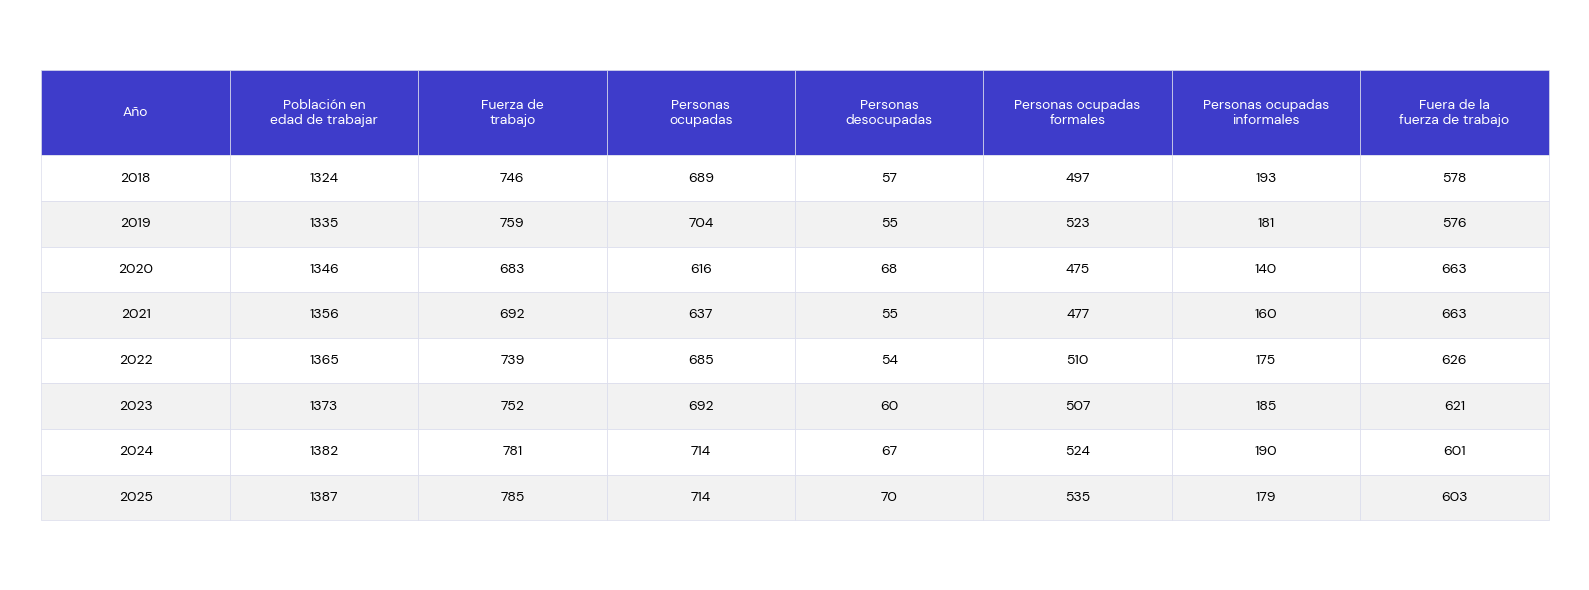

<ipython-input-79-2415737670>:147: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


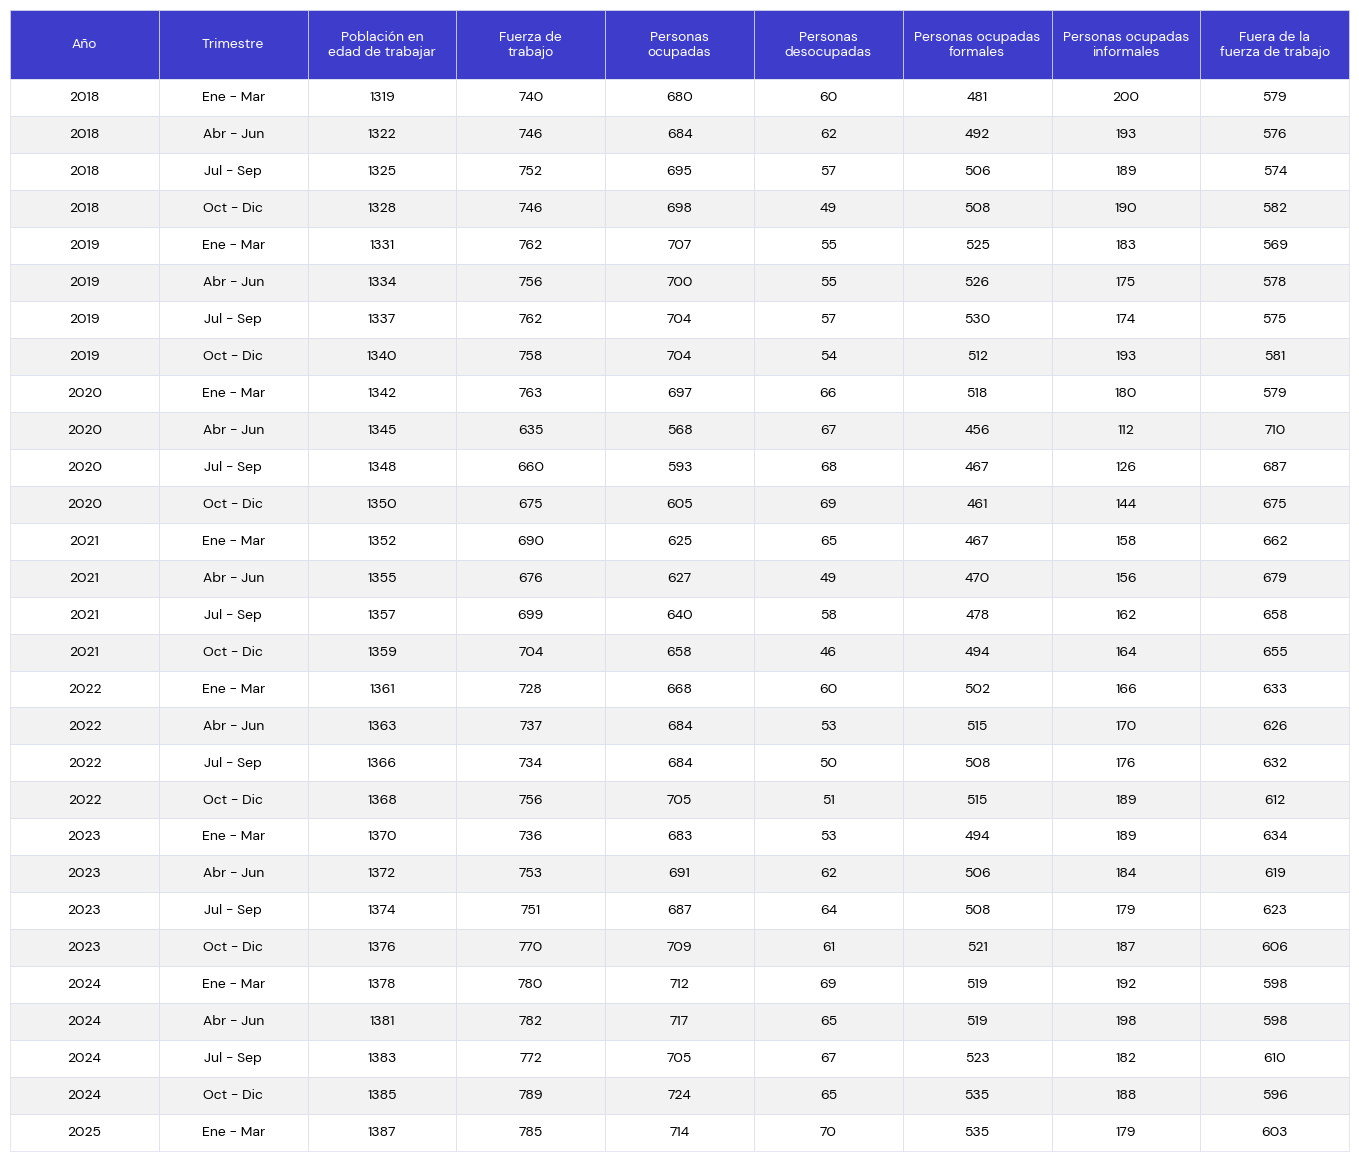

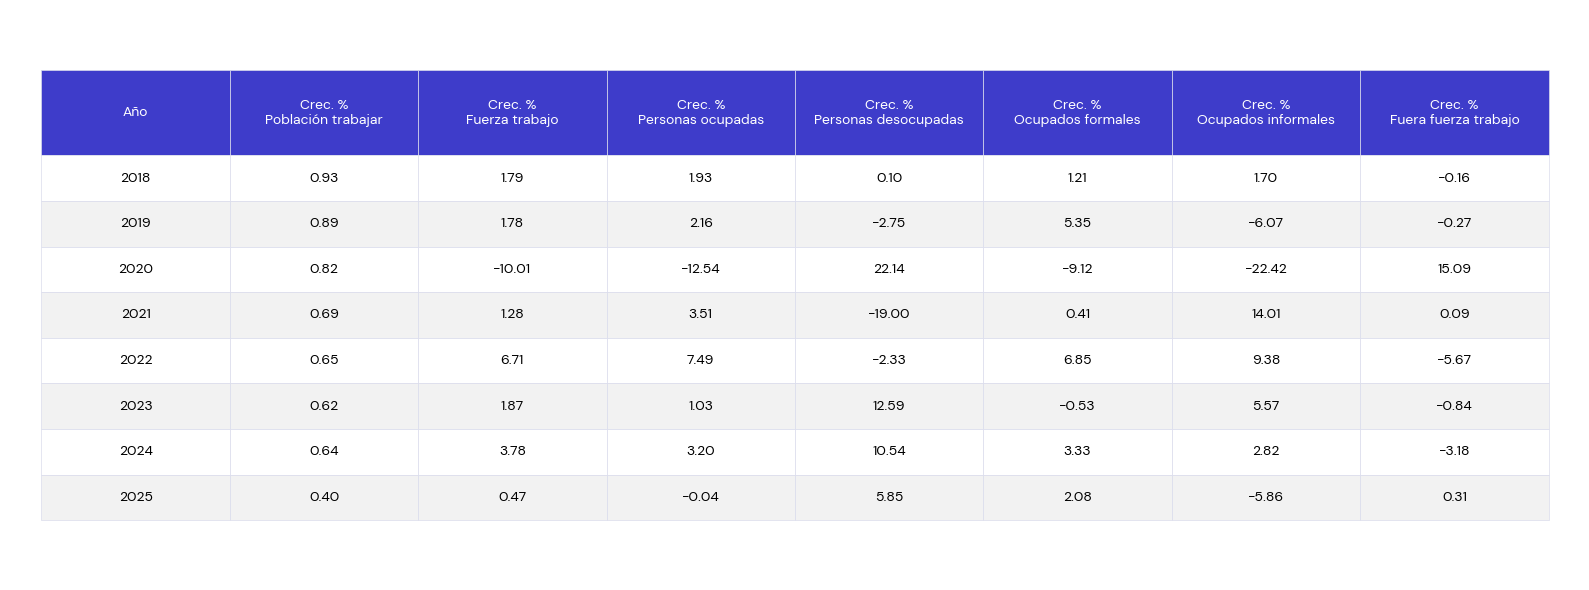

<ipython-input-79-2415737670>:147: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


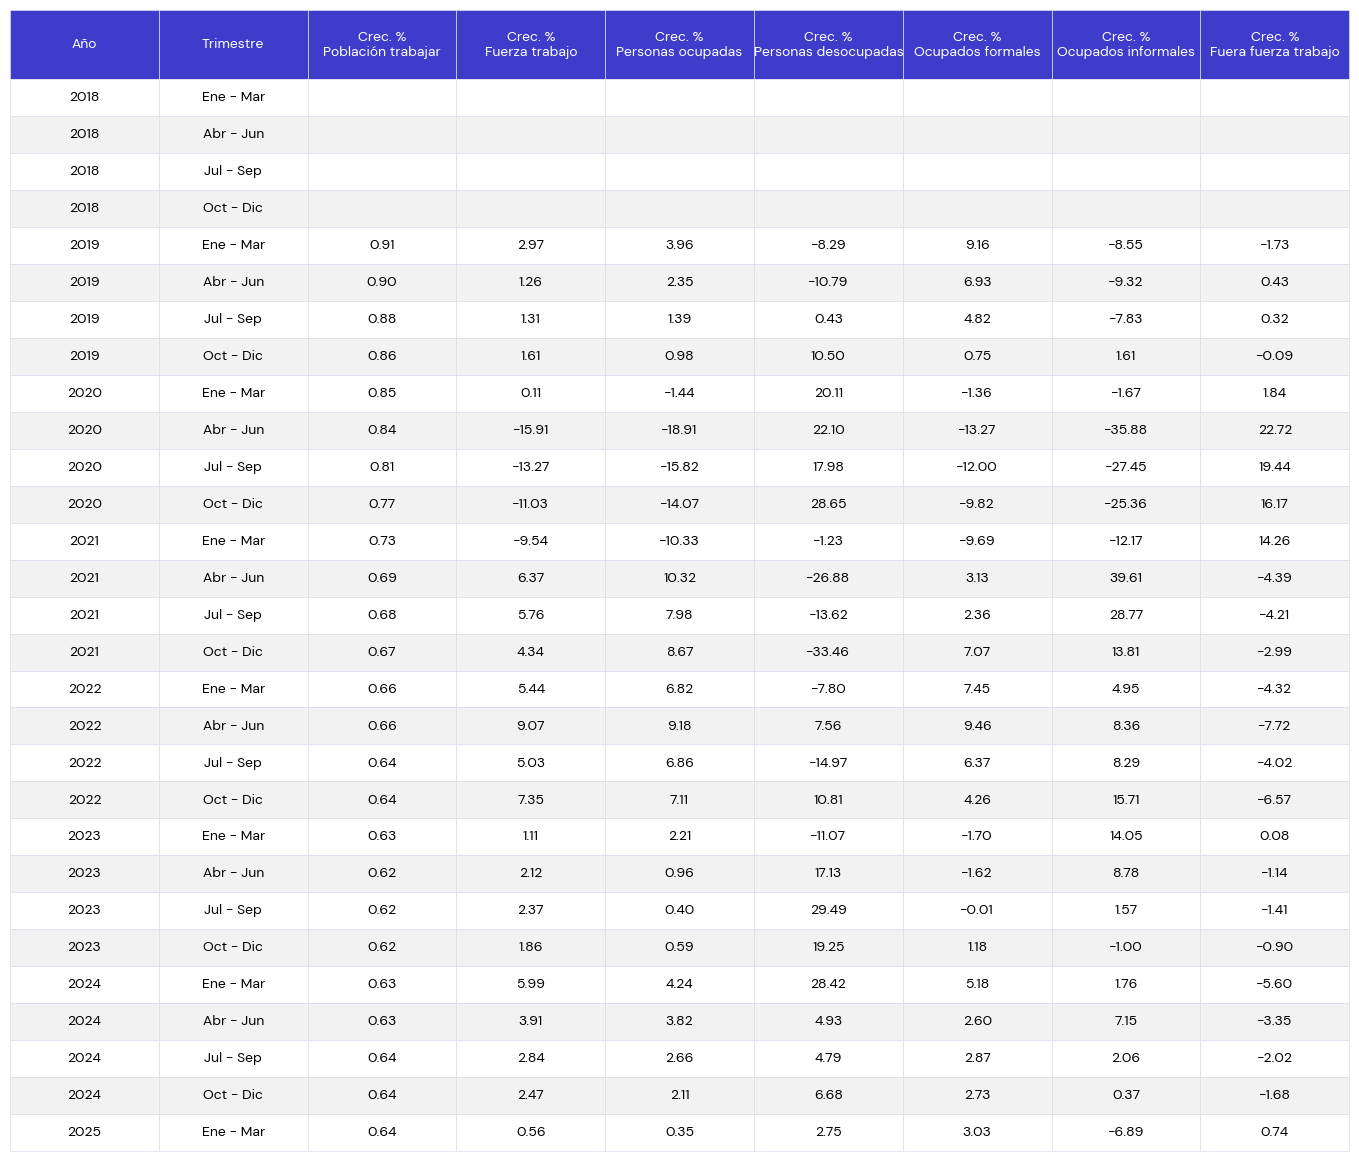

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from pathlib import Path

# ‚îÄ‚îÄ‚îÄ 1. Fuente personalizada (opcional) ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
font_path = "/content/drive/MyDrive/Data/fonts/DMSans-Regular.ttf"
if Path(font_path).exists():
    fm.fontManager.addfont(font_path)
    dm_font = fm.FontProperties(fname=font_path)
else:
    dm_font = fm.FontProperties()

# ‚îÄ‚îÄ‚îÄ 2. Cargar y preparar datos ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
df = pd.read_excel(ruta, sheet_name="panel_data")
df_bio = df[df["region_name"] == "Biob√≠o"].copy()

orden_trimestres = {"Ene - Mar": 1, "Abr - Jun": 2, "Jul - Sep": 3, "Oct - Dic": 4}
df_bio["orden"] = df_bio["Trimestre"].map(orden_trimestres)
df_bio = df_bio.sort_values(["A√±o", "orden"]).drop(columns="orden")

column_map = {
    "PET_indicadoresprincipales": "Poblaci√≥n en\nedad de trabajar",
    "FT_TOT_indicadoresprincipales": "Fuerza de\ntrabajo",
    "PO_TOT_indicadoresprincipales": "Personas\nocupadas",
    "PDO_TOT_indicadoresprincipales": "Personas\ndesocupadas",
    "PO_F_TOT_informalidadrama": "Personas ocupadas\nformales",
    "PO_I_TOT_informalidadrama": "Personas ocupadas\ninformales",
    "FFT_TOT_indicadoresprincipales": "Fuera de la\nfuerza de trabajo"
}
variables = list(column_map.values())
column_keys = list(column_map.keys())

# ‚îÄ‚îÄ‚îÄ 3. Datos anuales completos ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
df_anual_full = df_bio[["A√±o"] + column_keys].groupby("A√±o").mean(numeric_only=True).reset_index()
df_anual_full = df_anual_full.rename(columns=column_map)

# ‚îÄ‚îÄ‚îÄ 4. Tabla 1: Promedios anuales desde 2018, redondeados ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
df_anual = df_anual_full[df_anual_full["A√±o"] >= 2018].copy()
df_anual["A√±o"] = df_anual["A√±o"].astype(int).astype(str)
# Redondear correctamente y convertir a entero
for var in variables:
    df_anual[var] = df_anual[var].fillna(0).round().astype(int).astype(str)

# ‚îÄ‚îÄ‚îÄ 5. Tabla 2: Trimestral desde 2018, redondeados ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
df_trim = df_bio[df_bio["A√±o"] >= 2018][["A√±o", "Trimestre"] + column_keys].copy()
df_trim = df_trim.rename(columns=column_map)
# Redondear correctamente y convertir a entero
for var in variables:
    df_trim[var] = df_trim[var].fillna(0).round().astype(int).astype(str)

# ‚îÄ‚îÄ‚îÄ 6. Tabla 3: Crecimiento % anual desde base completa ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
df_var_anual = df_anual_full.copy()
for var in variables:
    df_var_anual[f"Crecimiento % {var}"] = df_var_anual[var].pct_change() * 100

# Crear encabezados m√°s cortos para las variaciones
var_columns_map = {
    f"Crecimiento % {variables[0]}": "Crec. %\nPoblaci√≥n trabajar",
    f"Crecimiento % {variables[1]}": "Crec. %\nFuerza trabajo",
    f"Crecimiento % {variables[2]}": "Crec. %\nPersonas ocupadas",
    f"Crecimiento % {variables[3]}": "Crec. %\nPersonas desocupadas",
    f"Crecimiento % {variables[4]}": "Crec. %\nOcupados formales",
    f"Crecimiento % {variables[5]}": "Crec. %\nOcupados informales",
    f"Crecimiento % {variables[6]}": "Crec. %\nFuera fuerza trabajo"
}

df_var_anual = df_var_anual[["A√±o"] + [f"Crecimiento % {v}" for v in variables]]
df_var_anual = df_var_anual.rename(columns=var_columns_map)
df_var_anual = df_var_anual[df_var_anual["A√±o"] >= 2018].copy()
df_var_anual["A√±o"] = df_var_anual["A√±o"].astype(int).astype(str)
# Mantener 2 decimales en las variaciones
crecimiento_cols = [col for col in df_var_anual.columns if col.startswith("Crec.")]
for col in crecimiento_cols:
    df_var_anual[col] = df_var_anual[col].round(2)

# ‚îÄ‚îÄ‚îÄ 7. Tabla 4: Crecimiento % trimestral desde base completa ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
df_var_trim = df_bio[df_bio["A√±o"] >= 2018][["A√±o", "Trimestre"] + column_keys].copy()
df_var_trim = df_var_trim.rename(columns=column_map)
for var in variables:
    df_var_trim[f"Crecimiento % {var}"] = (
        df_var_trim.groupby("Trimestre")[var].pct_change() * 100
    )

# Crear encabezados m√°s cortos para las variaciones trimestrales
var_columns_map_trim = {
    f"Crecimiento % {variables[0]}": "Crec. %\nPoblaci√≥n trabajar",
    f"Crecimiento % {variables[1]}": "Crec. %\nFuerza trabajo",
    f"Crecimiento % {variables[2]}": "Crec. %\nPersonas ocupadas",
    f"Crecimiento % {variables[3]}": "Crec. %\nPersonas desocupadas",
    f"Crecimiento % {variables[4]}": "Crec. %\nOcupados formales",
    f"Crecimiento % {variables[5]}": "Crec. %\nOcupados informales",
    f"Crecimiento % {variables[6]}": "Crec. %\nFuera fuerza trabajo"
}

df_var_trim = df_var_trim[["A√±o", "Trimestre"] + [f"Crecimiento % {v}" for v in variables]]
df_var_trim = df_var_trim.rename(columns=var_columns_map_trim)
# Mantener 2 decimales en las variaciones trimestrales
crecimiento_cols_trim = [col for col in df_var_trim.columns if col.startswith("Crec.")]
for col in crecimiento_cols_trim:
    df_var_trim[col] = df_var_trim[col].round(2)

# ‚îÄ‚îÄ‚îÄ 8. Funci√≥n para mostrar tablas como imagen ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
def mostrar_tabla(df, title=""):
    fig, ax = plt.subplots(figsize=(16, 6))
    ax.axis("off")

    # Convertir DataFrame a strings para mostrar
    df_display = df.copy()
    for col in df_display.columns:
        if col not in ["A√±o", "Trimestre"]:
            # Si es columna num√©rica, formatear apropiadamente
            if df_display[col].dtype in ['float64', 'int64', 'float32', 'int32']:
                if any('Crec.' in str(c) for c in df_display.columns):
                    # Es tabla de variaciones, mantener 2 decimales
                    df_display[col] = df_display[col].apply(lambda x: f"{x:.2f}" if pd.notna(x) else "")
                else:
                    # Es tabla de valores absolutos, sin decimales
                    df_display[col] = df_display[col].apply(lambda x: f"{int(x)}" if pd.notna(x) else "")

    tabla = ax.table(
        cellText=[df_display.columns.tolist()] + df_display.astype(str).values.tolist(),
        cellLoc='center',
        loc='center'
    )
    tabla.auto_set_font_size(False)
    tabla.set_fontsize(11)
    tabla.scale(1.2, 2.0)

    for (row, col), cell in tabla.get_celld().items():
        if row == 0:
            cell.set_facecolor("#3E3CCA")
            cell.set_text_props(color='white', weight='bold', fontproperties=dm_font)
            cell.set_height(0.15)
        else:
            cell.set_facecolor("white" if row % 2 else "#f2f2f2")
            cell.set_text_props(fontproperties=dm_font)
            cell.set_height(0.08)
        cell.set_edgecolor("#DADCEC")
        cell.set_linewidth(0.5)
        cell.set_width(0.12)

    if title:
        plt.title(title, fontsize=14, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.show()

# ‚îÄ‚îÄ‚îÄ 9. Mostrar todas las tablas ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
mostrar_tabla(df_anual)
mostrar_tabla(df_trim)
mostrar_tabla(df_var_anual)
mostrar_tabla(df_var_trim)

# Gr√°ficos linea y barras

In [ ]:
# ‚îÄ‚îÄ‚îÄ 1. Cargar DM Sans desde Google Drive ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np

# Rutas donde buscar las fuentes DM Sans en tu Drive
FONT_PATHS = [
    "/content/drive/MyDrive/Data/fonts/",  # Carpeta fonts en Data
]

# Nombres de archivos de fuente a buscar
FONT_FILES = [
    "DMSans-Regular.ttf",
    "DMSans-Bold.ttf",
    "DMSans-Italic.ttf",
]

print("üîç Buscando fuentes DM Sans en Google Drive...")
found_fonts = []

# Buscar fuentes en las rutas especificadas
for base_path in FONT_PATHS:
    font_dir = Path(base_path)
    if font_dir.exists():
        print(f"   üìÅ Revisando: {font_dir}")
        for font_file in FONT_FILES:
            font_path = font_dir / font_file
            if font_path.exists():
                found_fonts.append(font_path)
                print(f"   ‚úÖ Encontrada: {font_file}")
    else:
        print(f"   ‚ö†Ô∏è No existe: {font_dir}")

# ‚îÄ‚îÄ‚îÄ 2. Registrar fuentes encontradas ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
registered_fonts = []
dm_font_name = None

for font_path in found_fonts:
    try:
        # Registrar la fuente
        fm.fontManager.addfont(str(font_path))
        registered_fonts.append(font_path)

        # Obtener el nombre real de la fuente
        font_props = fm.FontProperties(fname=str(font_path))
        font_name = font_props.get_name()

        if not dm_font_name:  # Usar la primera fuente como principal
            dm_font_name = font_name

        print(f"‚úÖ Registrada: {font_path.name} ‚Üí '{font_name}'")

    except Exception as e:
        print(f"‚ùå Error registrando {font_path.name}: {e}")

# ‚îÄ‚îÄ‚îÄ 3. Configurar matplotlib para usar DM Sans ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
if dm_font_name:
    print(f"\nüéØ Configurando '{dm_font_name}' como fuente principal")

    # M√©todo 1: Configurar rcParams
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': [dm_font_name, 'DejaVu Sans', 'Arial', 'Liberation Sans']
    })

    # M√©todo 2: Crear FontProperties para uso directo
    dm_font_props = fm.FontProperties(family=dm_font_name)
    dm_font_bold = fm.FontProperties(family=dm_font_name, weight='bold')

    print("‚úÖ DM Sans configurado exitosamente")


# ‚îÄ‚îÄ‚îÄ 4. Configuraci√≥n de datos y paleta ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
PANEL_PATH = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx")
OUT_FILE   = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/variacion_tdo.png")

PALETTE = [
    "#4c5256", "#2e3351", "#161233", "#3e3cca",
    "#c0c8eb", "#798dbf", "#ac78ff", "#48aee8",
]

# ‚îÄ‚îÄ‚îÄ 5. Cargar y procesar datos ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
df = pd.read_excel(PANEL_PATH, sheet_name="biobio_vs_nacional")
df["Fecha"] = pd.to_datetime(df["Fecha"])
df.sort_values("Fecha", inplace=True)

# Extraer trimestre m√≥vil
df["Trimestre"] = df["Fecha"].dt.strftime("%b-%Y")

def variacion_interanual_pp(df_region):
    df_region = df_region.sort_values("Fecha").copy()
    df_region["Trimestre"] = df_region["Fecha"].dt.strftime("%b")
    df_region["var"] = (
        df_region.groupby("Trimestre")["T_TDO_indicadoresprincipales"]
        .transform(lambda s: s - s.shift(4))
    )
    return df_region

nac = variacion_interanual_pp(df[df["region_name"] == "Nacional"].copy())
bio = variacion_interanual_pp(df[df["region_name"] == "Biob√≠o"].copy())

# ‚îÄ‚îÄ‚îÄ 6. Crear gr√°fico con DM Sans ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

import matplotlib.dates as mdates
from matplotlib.dates import date2num

fig, ax = plt.subplots(figsize=(12, 7))

# Pandemia: sombreado
ax.axvspan(
    date2num(pd.to_datetime("2020-03-01")),
    date2num(pd.to_datetime("2021-10-01")),
    color="#3e3cca", alpha=0.04, zorder=0
)

# L√≠neas
ax.plot(nac["Fecha"], nac["var"], label="Nacional", color=PALETTE[3], linewidth=2.5, zorder=2)
ax.plot(bio["Fecha"], bio["var"], label="Biob√≠o", color=PALETTE[6], linewidth=2.5, zorder=2)

# L√≠nea 0
ax.axhline(0, color=PALETTE[0], linestyle="--", linewidth=1, alpha=0.6, zorder=1)

# Texto pandemia
ax.text(
    pd.to_datetime("2020-11-15"),
    ax.get_ylim()[1] * 1.03,
    "Pandemia",
    fontproperties=dm_font_props,
    fontsize=12,
    ha="center", va="bottom",
    color="#666666", alpha=0.9
)

# Ejes
ax.set_ylabel("Variaci√≥n interanual (pp)",
              fontproperties=dm_font_bold, fontsize=14, color=PALETTE[1])
ax.set_xlabel("")
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=11)

# Fuente en ticks
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font_props)

# Est√©tica
ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color(PALETTE[0])
ax.spines["bottom"].set_color(PALETTE[0])
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

# Leyenda
ax.legend(frameon=False, loc="upper left", fontsize=12, prop=dm_font_props)

plt.tight_layout()
plt.show()



# ‚îÄ‚îÄ‚îÄ 7. Verificar fuente y mostrar ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
print(f"\nüé® Fuente configurada: {dm_font_name}")
print(f"üé® Fuente en t√≠tulo: {ax.title.get_fontname()}")
print(f"üìä Total fuentes registradas: {len(registered_fonts)}")

plt.show()



üîç Buscando fuentes DM Sans en Google Drive...
   üìÅ Revisando: /content/drive/MyDrive/Data/fonts
   ‚úÖ Encontrada: DMSans-Regular.ttf
   ‚úÖ Encontrada: DMSans-Bold.ttf
   ‚úÖ Encontrada: DMSans-Italic.ttf
‚úÖ Registrada: DMSans-Regular.ttf ‚Üí 'DM Sans'
‚úÖ Registrada: DMSans-Bold.ttf ‚Üí 'DM Sans'
‚úÖ Registrada: DMSans-Italic.ttf ‚Üí 'DM Sans'

üéØ Configurando 'DM Sans' como fuente principal
‚úÖ DM Sans configurado exitosamente



üé® Fuente configurada: DM Sans
üé® Fuente en t√≠tulo: DM Sans
üìä Total fuentes registradas: 3


üîç Buscando fuentes DM Sans en Google Drive...
   üìÅ Revisando: /content/drive/MyDrive/Data/fonts
   ‚úÖ Encontrada: DMSans-Regular.ttf
   ‚úÖ Encontrada: DMSans-Bold.ttf
   ‚úÖ Encontrada: DMSans-Italic.ttf
‚úÖ Registrada: DMSans-Regular.ttf ‚Üí 'DM Sans'
‚úÖ Registrada: DMSans-Bold.ttf ‚Üí 'DM Sans'
‚úÖ Registrada: DMSans-Italic.ttf ‚Üí 'DM Sans'

üéØ Configurando 'DM Sans' como fuente principal
‚úÖ DM Sans configurado exitosamente

üé® Fuente configurada: DM Sans
üìä Total fuentes registradas: 3


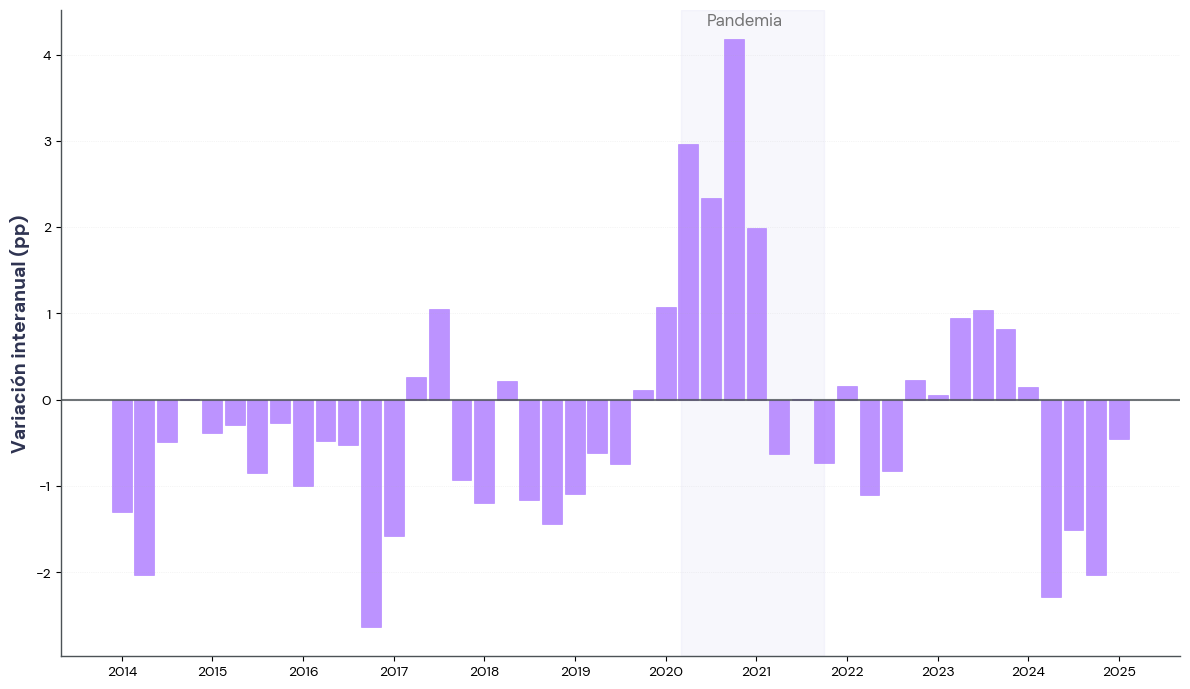

In [ ]:
# ‚îÄ‚îÄ‚îÄ 1. Cargar DM Sans desde Google Drive ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np

# Rutas donde buscar las fuentes DM Sans en tu Drive
FONT_PATHS = [
    "/content/drive/MyDrive/Data/fonts/",  # Carpeta fonts en Data
]

# Nombres de archivos de fuente a buscar
FONT_FILES = [
    "DMSans-Regular.ttf",
    "DMSans-Bold.ttf",
    "DMSans-Italic.ttf",
]

print("üîç Buscando fuentes DM Sans en Google Drive...")
found_fonts = []

# Buscar fuentes en las rutas especificadas
for base_path in FONT_PATHS:
    font_dir = Path(base_path)
    if font_dir.exists():
        print(f"   üìÅ Revisando: {font_dir}")
        for font_file in FONT_FILES:
            font_path = font_dir / font_file
            if font_path.exists():
                found_fonts.append(font_path)
                print(f"   ‚úÖ Encontrada: {font_file}")
    else:
        print(f"   ‚ö†Ô∏è No existe: {font_dir}")

# ‚îÄ‚îÄ‚îÄ 2. Registrar fuentes encontradas ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
registered_fonts = []
dm_font_name = None

for font_path in found_fonts:
    try:
        # Registrar la fuente
        fm.fontManager.addfont(str(font_path))
        registered_fonts.append(font_path)

        # Obtener el nombre real de la fuente
        font_props = fm.FontProperties(fname=str(font_path))
        font_name = font_props.get_name()

        if not dm_font_name:  # Usar la primera fuente como principal
            dm_font_name = font_name

        print(f"‚úÖ Registrada: {font_path.name} ‚Üí '{font_name}'")

    except Exception as e:
        print(f"‚ùå Error registrando {font_path.name}: {e}")

# ‚îÄ‚îÄ‚îÄ 3. Configurar matplotlib para usar DM Sans ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
if dm_font_name:
    print(f"\nüéØ Configurando '{dm_font_name}' como fuente principal")

    # M√©todo 1: Configurar rcParams
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': [dm_font_name, 'DejaVu Sans', 'Arial', 'Liberation Sans']
    })

    # M√©todo 2: Crear FontProperties para uso directo
    dm_font_props = fm.FontProperties(family=dm_font_name)
    dm_font_bold = fm.FontProperties(family=dm_font_name, weight='bold')

    print("‚úÖ DM Sans configurado exitosamente")


# ‚îÄ‚îÄ‚îÄ 4. Configuraci√≥n de datos y paleta ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
PANEL_PATH = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx")
OUT_FILE   = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/variacion_tdo_barras.png")

PALETTE = [
    "#4c5256", "#2e3351", "#161233", "#3e3cca",
    "#c0c8eb", "#798dbf", "#ac78ff", "#48aee8",
]

# ‚îÄ‚îÄ‚îÄ 5. Cargar y procesar datos ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
df = pd.read_excel(PANEL_PATH, sheet_name="biobio_vs_nacional")
df["Fecha"] = pd.to_datetime(df["Fecha"])
df.sort_values("Fecha", inplace=True)

# Extraer trimestre m√≥vil
df["Trimestre"] = df["Fecha"].dt.strftime("%b-%Y")

def variacion_interanual_pp(df_region):
    df_region = df_region.sort_values("Fecha").copy()
    df_region["Trimestre"] = df_region["Fecha"].dt.strftime("%b")
    df_region["var"] = (
        df_region.groupby("Trimestre")["T_TDO_indicadoresprincipales"]
        .transform(lambda s: s - s.shift(4))
    )
    return df_region

# Solo procesar Biob√≠o
bio = variacion_interanual_pp(df[df["region_name"] == "Biob√≠o"].copy())

# ‚îÄ‚îÄ‚îÄ 6. Crear gr√°fico de barras con DM Sans ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

import matplotlib.dates as mdates
from matplotlib.dates import date2num

fig, ax = plt.subplots(figsize=(12, 7))

# Crear barras
bars = ax.bar(bio["Fecha"], bio["var"],
              color=PALETTE[6], alpha=0.8,
              width=80, edgecolor=PALETTE[6], linewidth=0.5)

# Colorear barras seg√∫n valor (positivo/negativo)
for i, (bar, val) in enumerate(zip(bars, bio["var"])):
    if val >= 0:
        bar.set_color(PALETTE[6])  # Color principal para positivos
    else:
        bar.set_color(PALETTE[6])  # Color alternativo para negativos

# Pandemia: sombreado
ax.axvspan(
    date2num(pd.to_datetime("2020-03-01")),
    date2num(pd.to_datetime("2021-10-01")),
    color="#3e3cca", alpha=0.04, zorder=0
)

# L√≠nea 0
ax.axhline(0, color=PALETTE[0], linestyle="-", linewidth=1.5, alpha=0.8, zorder=3)

# Texto pandemia
ax.text(
    pd.to_datetime("2020-11-15"),
    ax.get_ylim()[1] * 0.95,
    "Pandemia",
    fontproperties=dm_font_props,
    fontsize=12,
    ha="center", va="bottom",
    color="#666666", alpha=0.9
)

# Ejes
ax.set_ylabel("Variaci√≥n interanual (pp)",
              fontproperties=dm_font_bold, fontsize=14, color=PALETTE[1])
ax.set_xlabel("")
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=11)

# Fuente en ticks
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font_props)

# Est√©tica
ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color(PALETTE[0])
ax.spines["bottom"].set_color(PALETTE[0])
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)


plt.tight_layout()

# ‚îÄ‚îÄ‚îÄ 7. Verificar fuente y mostrar ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
print(f"\nüé® Fuente configurada: {dm_font_name}")
print(f"üìä Total fuentes registradas: {len(registered_fonts)}")

plt.show()

# Opcional: Guardar el gr√°fico
# plt.savefig(OUT_FILE, dpi=300, bbox_inches='tight', facecolor='white')

üîç Buscando fuentes DM Sans en Google Drive...
   üìÅ Revisando: /content/drive/MyDrive/Data/fonts
   ‚úÖ Encontrada: DMSans-Regular.ttf
   ‚úÖ Encontrada: DMSans-Bold.ttf
   ‚úÖ Encontrada: DMSans-Italic.ttf
‚úÖ Registrada: DMSans-Regular.ttf ‚Üí 'DM Sans'
‚úÖ Registrada: DMSans-Bold.ttf ‚Üí 'DM Sans'
‚úÖ Registrada: DMSans-Italic.ttf ‚Üí 'DM Sans'

üéØ Configurando 'DM Sans' como fuente principal
‚úÖ DM Sans configurado exitosamente

üé® Fuente configurada: DM Sans
üìä Total fuentes registradas: 3

üìã Datos procesados:
A√±o | TDO Promedio | Cambio (pp)
-----------------------------------
2011 | 8.33% | -1.15
2012 | 8.47% | +0.14
2013 | 8.05% | -0.42
2014 | 8.52% | +0.47
2015 | 7.87% | -0.65
2016 | 7.31% | -0.56
2017 | 7.76% | +0.44
2018 | 7.63% | -0.12
2019 | 7.29% | -0.34
2020 | 9.95% | +2.66
2021 | 7.92% | -2.03
2022 | 7.25% | -0.67
2023 | 8.00% | +0.75
2024 | 8.53% | +0.53
2025 | 8.98% | +0.46


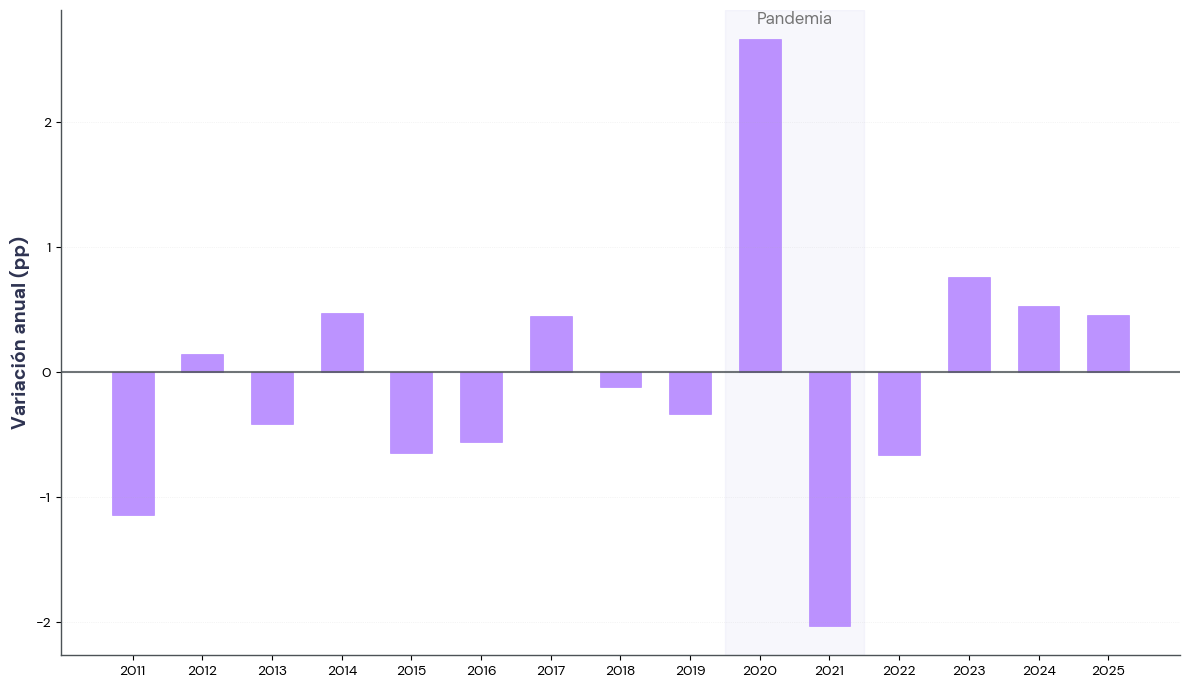

In [ ]:
# ‚îÄ‚îÄ‚îÄ 1. Cargar DM Sans desde Google Drive ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np

# Rutas donde buscar las fuentes DM Sans en tu Drive
FONT_PATHS = [
    "/content/drive/MyDrive/Data/fonts/",  # Carpeta fonts en Data
]

# Nombres de archivos de fuente a buscar
FONT_FILES = [
    "DMSans-Regular.ttf",
    "DMSans-Bold.ttf",
    "DMSans-Italic.ttf",
]

print("üîç Buscando fuentes DM Sans en Google Drive...")
found_fonts = []

# Buscar fuentes en las rutas especificadas
for base_path in FONT_PATHS:
    font_dir = Path(base_path)
    if font_dir.exists():
        print(f"   üìÅ Revisando: {font_dir}")
        for font_file in FONT_FILES:
            font_path = font_dir / font_file
            if font_path.exists():
                found_fonts.append(font_path)
                print(f"   ‚úÖ Encontrada: {font_file}")
    else:
        print(f"   ‚ö†Ô∏è No existe: {font_dir}")

# ‚îÄ‚îÄ‚îÄ 2. Registrar fuentes encontradas ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
registered_fonts = []
dm_font_name = None

for font_path in found_fonts:
    try:
        # Registrar la fuente
        fm.fontManager.addfont(str(font_path))
        registered_fonts.append(font_path)

        # Obtener el nombre real de la fuente
        font_props = fm.FontProperties(fname=str(font_path))
        font_name = font_props.get_name()

        if not dm_font_name:  # Usar la primera fuente como principal
            dm_font_name = font_name

        print(f"‚úÖ Registrada: {font_path.name} ‚Üí '{font_name}'")

    except Exception as e:
        print(f"‚ùå Error registrando {font_path.name}: {e}")

# ‚îÄ‚îÄ‚îÄ 3. Configurar matplotlib para usar DM Sans ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
if dm_font_name:
    print(f"\nüéØ Configurando '{dm_font_name}' como fuente principal")

    # M√©todo 1: Configurar rcParams
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': [dm_font_name, 'DejaVu Sans', 'Arial', 'Liberation Sans']
    })

    # M√©todo 2: Crear FontProperties para uso directo
    dm_font_props = fm.FontProperties(family=dm_font_name)
    dm_font_bold = fm.FontProperties(family=dm_font_name, weight='bold')

    print("‚úÖ DM Sans configurado exitosamente")


# ‚îÄ‚îÄ‚îÄ 4. Configuraci√≥n de datos y paleta ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
PANEL_PATH = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx")
OUT_FILE   = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/variacion_tdo_barras.png")

PALETTE = [
    "#4c5256", "#2e3351", "#161233", "#3e3cca",
    "#c0c8eb", "#798dbf", "#ac78ff", "#48aee8",
]

# ‚îÄ‚îÄ‚îÄ 5. Cargar y procesar datos ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
df = pd.read_excel(PANEL_PATH, sheet_name="biobio_vs_nacional")
df["Fecha"] = pd.to_datetime(df["Fecha"])
df.sort_values("Fecha", inplace=True)

# Filtrar solo Biob√≠o
bio_df = df[df["region_name"] == "Biob√≠o"].copy()

# Extraer a√±o
bio_df["A√±o"] = bio_df["Fecha"].dt.year

# Calcular promedio anual del TDO por a√±o
bio_anual = bio_df.groupby("A√±o")["T_TDO_indicadoresprincipales"].mean().reset_index()
bio_anual.columns = ["A√±o", "TDO_promedio"]

# Calcular cambio interanual en puntos porcentuales
bio_anual["cambio_pp"] = bio_anual["TDO_promedio"].diff()

# Eliminar el primer a√±o (no tiene cambio)
bio = bio_anual.dropna().copy()

# ‚îÄ‚îÄ‚îÄ 6. Crear gr√°fico de barras con DM Sans ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

fig, ax = plt.subplots(figsize=(12, 7))

# Crear barras
bars = ax.bar(bio["A√±o"], bio["cambio_pp"],
              color=PALETTE[6], alpha=0.8,
              width=0.6, edgecolor=PALETTE[6], linewidth=0.5)

# Colorear barras seg√∫n valor (positivo/negativo)
for i, (bar, val) in enumerate(zip(bars, bio["cambio_pp"])):
    if val >= 0:
        bar.set_color(PALETTE[6])  # Color principal para positivos
    else:
        bar.set_color(PALETTE[6])  # Color alternativo para negativos

# Pandemia: sombreado (a√±os 2020-2021)
ax.axvspan(2019.5, 2021.5, color="#3e3cca", alpha=0.04, zorder=0)

# L√≠nea 0
ax.axhline(0, color=PALETTE[0], linestyle="-", linewidth=1.5, alpha=0.8, zorder=3)

# Texto pandemia
ax.text(2020.5, ax.get_ylim()[1] * 0.95, "Pandemia",
        fontproperties=dm_font_props, fontsize=12,
        ha="center", va="bottom", color="#666666", alpha=0.9)

# Ejes
ax.set_ylabel("Variaci√≥n anual (pp)",
              fontproperties=dm_font_bold, fontsize=14, color=PALETTE[1])
ax.set_xlabel("")

# Configurar eje X para a√±os
ax.set_xticks(bio["A√±o"])
ax.set_xticklabels([str(int(a√±o)) for a√±o in bio["A√±o"]])
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=11)

# Fuente en ticks
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font_props)

# Est√©tica
ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color(PALETTE[0])
ax.spines["bottom"].set_color(PALETTE[0])
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)


plt.tight_layout()

# ‚îÄ‚îÄ‚îÄ 7. Verificar fuente, mostrar datos y gr√°fico ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
print(f"\nüé® Fuente configurada: {dm_font_name}")
print(f"üìä Total fuentes registradas: {len(registered_fonts)}")

# Mostrar tabla de datos
print(f"\nüìã Datos procesados:")
print("A√±o | TDO Promedio | Cambio (pp)")
print("-" * 35)
for _, row in bio.iterrows():
    print(f"{int(row['A√±o'])} | {row['TDO_promedio']:.2f}% | {row['cambio_pp']:+.2f}")

plt.show()

# Opcional: Guardar el gr√°fico
# plt.savefig(OUT_FILE, dpi=300, bbox_inches='tight', facecolor='white')

üîç Buscando fuentes DM Sans en Google Drive...
   üìÅ Revisando: /content/drive/MyDrive/Data/fonts
   ‚úÖ Encontrada: DMSans-Regular.ttf
   ‚úÖ Encontrada: DMSans-Bold.ttf
   ‚úÖ Encontrada: DMSans-Italic.ttf
‚úÖ Registrada: DMSans-Regular.ttf ‚Üí 'DM Sans'
‚úÖ Registrada: DMSans-Bold.ttf ‚Üí 'DM Sans'
‚úÖ Registrada: DMSans-Italic.ttf ‚Üí 'DM Sans'

üéØ Configurando 'DM Sans' como fuente principal
‚úÖ DM Sans configurado exitosamente

üé® Fuente configurada: DM Sans
üìä Total fuentes registradas: 3


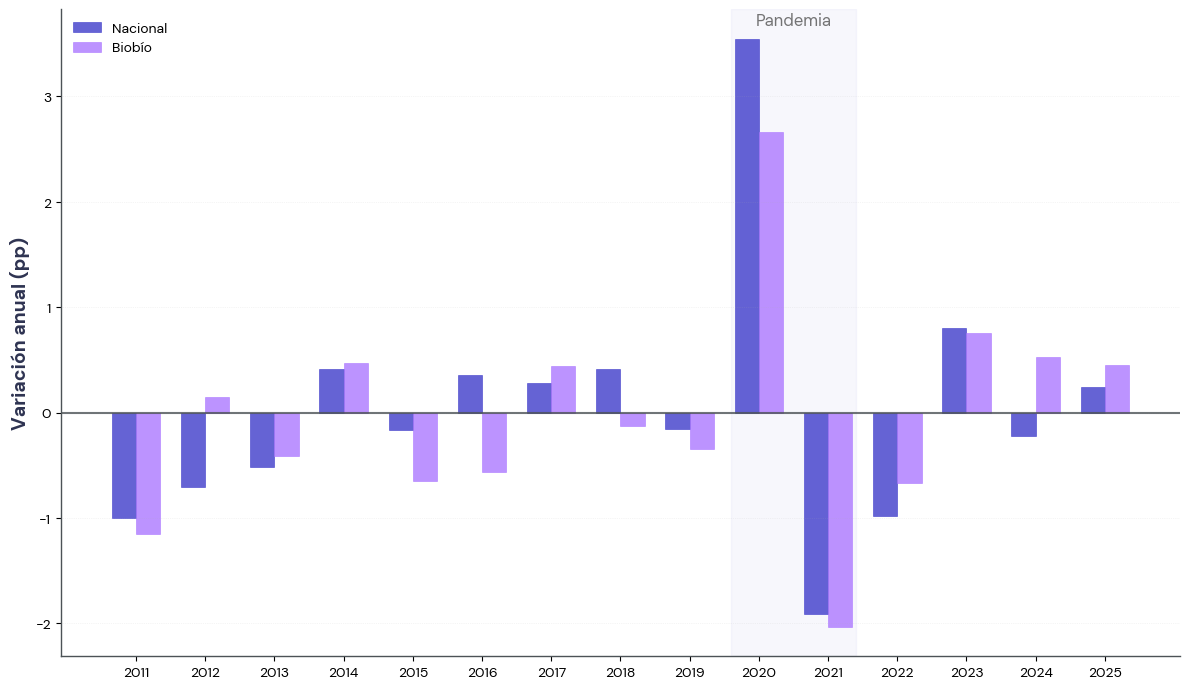

In [ ]:
# ‚îÄ‚îÄ‚îÄ 1. Cargar DM Sans desde Google Drive ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np

# Rutas donde buscar las fuentes DM Sans en tu Drive
FONT_PATHS = [
    "/content/drive/MyDrive/Data/fonts/",  # Carpeta fonts en Data
]

# Nombres de archivos de fuente a buscar
FONT_FILES = [
    "DMSans-Regular.ttf",
    "DMSans-Bold.ttf",
    "DMSans-Italic.ttf",
]

print("üîç Buscando fuentes DM Sans en Google Drive...")
found_fonts = []

# Buscar fuentes en las rutas especificadas
for base_path in FONT_PATHS:
    font_dir = Path(base_path)
    if font_dir.exists():
        print(f"   üìÅ Revisando: {font_dir}")
        for font_file in FONT_FILES:
            font_path = font_dir / font_file
            if font_path.exists():
                found_fonts.append(font_path)
                print(f"   ‚úÖ Encontrada: {font_file}")
    else:
        print(f"   ‚ö†Ô∏è No existe: {font_dir}")

# ‚îÄ‚îÄ‚îÄ 2. Registrar fuentes encontradas ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
registered_fonts = []
dm_font_name = None

for font_path in found_fonts:
    try:
        # Registrar la fuente
        fm.fontManager.addfont(str(font_path))
        registered_fonts.append(font_path)

        # Obtener el nombre real de la fuente
        font_props = fm.FontProperties(fname=str(font_path))
        font_name = font_props.get_name()

        if not dm_font_name:  # Usar la primera fuente como principal
            dm_font_name = font_name

        print(f"‚úÖ Registrada: {font_path.name} ‚Üí '{font_name}'")

    except Exception as e:
        print(f"‚ùå Error registrando {font_path.name}: {e}")

# ‚îÄ‚îÄ‚îÄ 3. Configurar matplotlib para usar DM Sans ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
if dm_font_name:
    print(f"\nüéØ Configurando '{dm_font_name}' como fuente principal")

    # M√©todo 1: Configurar rcParams
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': [dm_font_name, 'DejaVu Sans', 'Arial', 'Liberation Sans']
    })

    # M√©todo 2: Crear FontProperties para uso directo
    dm_font_props = fm.FontProperties(family=dm_font_name)
    dm_font_bold = fm.FontProperties(family=dm_font_name, weight='bold')

    print("‚úÖ DM Sans configurado exitosamente")


# ‚îÄ‚îÄ‚îÄ 4. Configuraci√≥n de datos y paleta ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
PANEL_PATH = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx")
OUT_FILE   = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/variacion_tdo_barras.png")

PALETTE = [
    "#4c5256", "#2e3351", "#161233", "#3e3cca",
    "#c0c8eb", "#798dbf", "#ac78ff", "#48aee8",
]

# ‚îÄ‚îÄ‚îÄ 5. Cargar y procesar datos ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
df = pd.read_excel(PANEL_PATH, sheet_name="biobio_vs_nacional")
df["Fecha"] = pd.to_datetime(df["Fecha"])
df.sort_values("Fecha", inplace=True)

# Extraer a√±o
df["A√±o"] = df["Fecha"].dt.year

# Procesar tanto Nacional como Biob√≠o
def procesar_region(df_region, region_name):
    # Calcular promedio anual del TDO por a√±o
    anual = df_region.groupby("A√±o")["T_TDO_indicadoresprincipales"].mean().reset_index()
    anual.columns = ["A√±o", "TDO_promedio"]

    # Calcular cambio interanual en puntos porcentuales
    anual["cambio_pp"] = anual["TDO_promedio"].diff()
    anual["region"] = region_name

    # Eliminar el primer a√±o (no tiene cambio)
    return anual.dropna().copy()

# Procesar ambas regiones
nac = procesar_region(df[df["region_name"] == "Nacional"].copy(), "Nacional")
bio = procesar_region(df[df["region_name"] == "Biob√≠o"].copy(), "Biob√≠o")

# Combinar datos
datos_combinados = pd.concat([nac, bio], ignore_index=True)

# ‚îÄ‚îÄ‚îÄ 6. Crear gr√°fico de barras comparativo con DM Sans ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

fig, ax = plt.subplots(figsize=(12, 7))

# Preparar datos para barras agrupadas
a√±os = nac["A√±o"].values
x_pos = np.arange(len(a√±os))
width = 0.35

# Crear barras agrupadas
bars_nac = ax.bar(x_pos - width/2, nac["cambio_pp"], width,
                  label="Nacional", color=PALETTE[3], alpha=0.8,
                  edgecolor=PALETTE[3], linewidth=0.5)

bars_bio = ax.bar(x_pos + width/2, bio["cambio_pp"], width,
                  label="Biob√≠o", color=PALETTE[6], alpha=0.8,
                  edgecolor=PALETTE[6], linewidth=0.5)


# Pandemia: sombreado
# Encontrar posiciones de 2020 y 2021
a√±os_list = list(a√±os)
if 2020 in a√±os_list and 2021 in a√±os_list:
    pos_2020 = a√±os_list.index(2020)
    pos_2021 = a√±os_list.index(2021)
    ax.axvspan(pos_2020 - 0.4, pos_2021 + 0.4,
               color="#3e3cca", alpha=0.04, zorder=0)

# L√≠nea 0
ax.axhline(0, color=PALETTE[0], linestyle="-", linewidth=1.5, alpha=0.8, zorder=3)

# Texto pandemia
if 2020 in a√±os_list:
    pos_pandemia = a√±os_list.index(2020) + 0.5
    ax.text(pos_pandemia, ax.get_ylim()[1] * 0.95, "Pandemia",
            fontproperties=dm_font_props, fontsize=12,
            ha="center", va="bottom", color="#666666", alpha=0.9)

# Ejes
ax.set_ylabel("Variaci√≥n anual (pp)",
              fontproperties=dm_font_bold, fontsize=14, color=PALETTE[1])
ax.set_xlabel("")

# Configurar eje X
ax.set_xticks(x_pos)
ax.set_xticklabels([str(int(a√±o)) for a√±o in a√±os])
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=11)

# Fuente en ticks
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font_props)

# Est√©tica
ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color(PALETTE[0])
ax.spines["bottom"].set_color(PALETTE[0])
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

# Leyenda
ax.legend(frameon=False, loc="upper left", fontsize=12, prop=dm_font_props)


plt.tight_layout()

# ‚îÄ‚îÄ‚îÄ 7. Verificar fuente, mostrar datos y gr√°fico ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
print(f"\nüé® Fuente configurada: {dm_font_name}")
print(f"üìä Total fuentes registradas: {len(registered_fonts)}")


plt.show()

# Opcional: Guardar el gr√°fico
# plt.savefig(OUT_FILE, dpi=300, bbox_inches='tight', facecolor='white')

üîç Buscando fuentes DM Sans en Google Drive...
   üìÅ Revisando: /content/drive/MyDrive/Data/fonts
   ‚úÖ Encontrada: DMSans-Regular.ttf
   ‚úÖ Encontrada: DMSans-Bold.ttf
   ‚úÖ Encontrada: DMSans-Italic.ttf
‚úÖ Registrada: DMSans-Regular.ttf ‚Üí 'DM Sans'
‚úÖ Registrada: DMSans-Bold.ttf ‚Üí 'DM Sans'
‚úÖ Registrada: DMSans-Italic.ttf ‚Üí 'DM Sans'

üéØ Configurando 'DM Sans' como fuente principal
‚úÖ DM Sans configurado exitosamente


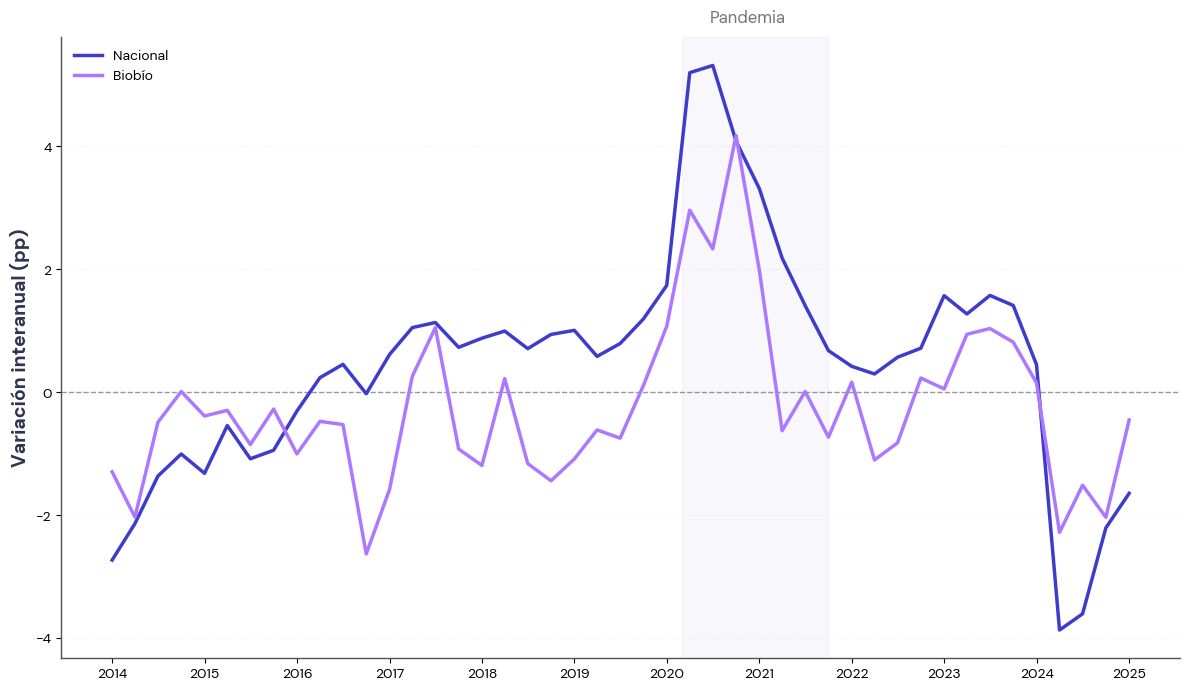


üé® Fuente configurada: DM Sans
üé® Fuente en t√≠tulo: DM Sans
üìä Total fuentes registradas: 3
‚úÖ Gr√°fico guardado: /content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/variacion_tdo.png


<Figure size 640x480 with 0 Axes>

In [ ]:

# ‚îÄ‚îÄ‚îÄ 1. Cargar DM Sans desde Google Drive ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np

# Rutas donde buscar las fuentes DM Sans en tu Drive
FONT_PATHS = [
    "/content/drive/MyDrive/Data/fonts/",  # Carpeta fonts en Data
]

# Nombres de archivos de fuente a buscar
FONT_FILES = [
    "DMSans-Regular.ttf",
    "DMSans-Bold.ttf",
    "DMSans-Italic.ttf",
]

print("üîç Buscando fuentes DM Sans en Google Drive...")
found_fonts = []

# Buscar fuentes en las rutas especificadas
for base_path in FONT_PATHS:
    font_dir = Path(base_path)
    if font_dir.exists():
        print(f"   üìÅ Revisando: {font_dir}")
        for font_file in FONT_FILES:
            font_path = font_dir / font_file
            if font_path.exists():
                found_fonts.append(font_path)
                print(f"   ‚úÖ Encontrada: {font_file}")
    else:
        print(f"   ‚ö†Ô∏è No existe: {font_dir}")

# ‚îÄ‚îÄ‚îÄ 2. Registrar fuentes encontradas ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
registered_fonts = []
dm_font_name = None

for font_path in found_fonts:
    try:
        # Registrar la fuente
        fm.fontManager.addfont(str(font_path))
        registered_fonts.append(font_path)

        # Obtener el nombre real de la fuente
        font_props = fm.FontProperties(fname=str(font_path))
        font_name = font_props.get_name()

        if not dm_font_name:  # Usar la primera fuente como principal
            dm_font_name = font_name

        print(f"‚úÖ Registrada: {font_path.name} ‚Üí '{font_name}'")

    except Exception as e:
        print(f"‚ùå Error registrando {font_path.name}: {e}")

# ‚îÄ‚îÄ‚îÄ 3. Configurar matplotlib para usar DM Sans ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
if dm_font_name:
    print(f"\nüéØ Configurando '{dm_font_name}' como fuente principal")

    # M√©todo 1: Configurar rcParams
    plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': [dm_font_name, 'DejaVu Sans', 'Arial', 'Liberation Sans']
    })

    # M√©todo 2: Crear FontProperties para uso directo
    dm_font_props = fm.FontProperties(family=dm_font_name)
    dm_font_bold = fm.FontProperties(family=dm_font_name, weight='bold')

    print("‚úÖ DM Sans configurado exitosamente")


# ‚îÄ‚îÄ‚îÄ 4. Configuraci√≥n de datos y paleta ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
PANEL_PATH = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx")
OUT_FILE   = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/variacion_tdo.png")

PALETTE = [
    "#4c5256", "#2e3351", "#161233", "#3e3cca",
    "#c0c8eb", "#798dbf", "#ac78ff", "#48aee8",
]

# ‚îÄ‚îÄ‚îÄ 5. Cargar y procesar datos ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
df = pd.read_excel(PANEL_PATH, sheet_name="biobio_vs_nacional")
df["Fecha"] = pd.to_datetime(df["Fecha"])
df.sort_values("Fecha", inplace=True)

# Extraer trimestre m√≥vil
df["Trimestre"] = df["Fecha"].dt.strftime("%b-%Y")

def variacion_interanual_pp(df_region):
    df_region = df_region.sort_values("Fecha").copy()
    df_region["Trimestre"] = df_region["Fecha"].dt.strftime("%b")
    df_region["var"] = (
        df_region.groupby("Trimestre")["T_TDO_indicadoresprincipales"]
        .transform(lambda s: s - s.shift(4))
    )
    return df_region

nac = variacion_interanual_pp(df[df["region_name"] == "Nacional"].copy())
bio = variacion_interanual_pp(df[df["region_name"] == "Biob√≠o"].copy())

# ‚îÄ‚îÄ‚îÄ 6. Crear gr√°fico con DM Sans ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

import matplotlib.dates as mdates
from matplotlib.dates import date2num

fig, ax = plt.subplots(figsize=(12, 7))

# Pandemia: sombreado
ax.axvspan(
    date2num(pd.to_datetime("2020-03-01")),
    date2num(pd.to_datetime("2021-10-01")),
    color="#3e3cca", alpha=0.04, zorder=0
)

# L√≠neas
ax.plot(nac["Fecha"], nac["var"], label="Nacional", color=PALETTE[3], linewidth=2.5, zorder=2)
ax.plot(bio["Fecha"], bio["var"], label="Biob√≠o", color=PALETTE[6], linewidth=2.5, zorder=2)

# L√≠nea 0
ax.axhline(0, color=PALETTE[0], linestyle="--", linewidth=1, alpha=0.6, zorder=1)

# Texto pandemia
ax.text(
    pd.to_datetime("2020-11-15"),
    ax.get_ylim()[1] * 1.03,
    "Pandemia",
    fontproperties=dm_font_props,
    fontsize=12,
    ha="center", va="bottom",
    color="#666666", alpha=0.9
)

# Ejes
ax.set_ylabel("Variaci√≥n interanual (pp)",
              fontproperties=dm_font_bold, fontsize=14, color=PALETTE[1])
ax.set_xlabel("")
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=11)

# Fuente en ticks
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font_props)

# Est√©tica
ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color(PALETTE[0])
ax.spines["bottom"].set_color(PALETTE[0])
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

# Leyenda
ax.legend(frameon=False, loc="upper left", fontsize=12, prop=dm_font_props)

plt.tight_layout()
plt.show()



# ‚îÄ‚îÄ‚îÄ 7. Verificar fuente y mostrar ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
print(f"\nüé® Fuente configurada: {dm_font_name}")
print(f"üé® Fuente en t√≠tulo: {ax.title.get_fontname()}")
print(f"üìä Total fuentes registradas: {len(registered_fonts)}")

plt.show()



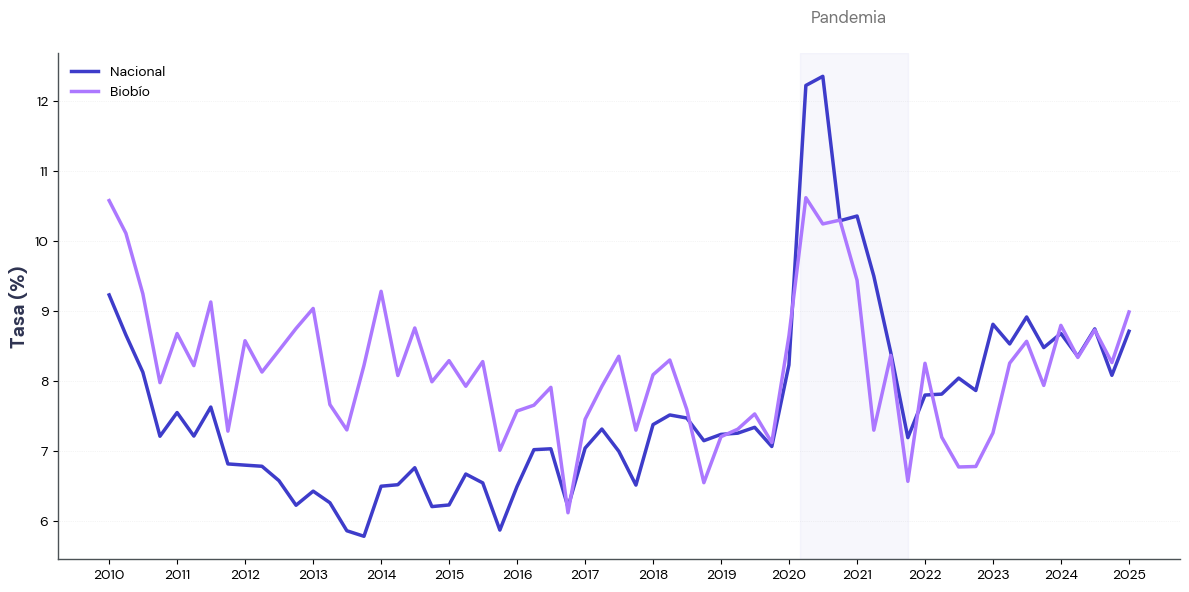

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
from pathlib import Path

# ‚îÄ‚îÄ‚îÄ Configurar fuente DM Sans ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
FONT_PATHS = ["/content/drive/MyDrive/Data/fonts/"]
FONT_FILES = ["DMSans-Regular.ttf", "DMSans-Bold.ttf", "DMSans-Italic.ttf"]
found_fonts = []
for base_path in FONT_PATHS:
    for font_file in FONT_FILES:
        font_path = Path(base_path) / font_file
        if font_path.exists():
            fm.fontManager.addfont(str(font_path))
            found_fonts.append(font_path)

dm_font_name = fm.FontProperties(fname=str(found_fonts[0])).get_name()
dm_font_props = fm.FontProperties(family=dm_font_name)
dm_font_bold  = fm.FontProperties(family=dm_font_name, weight="bold")

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': [dm_font_name, 'DejaVu Sans']
})


# ‚îÄ‚îÄ‚îÄ Cargar datos ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
df = pd.read_excel(ruta, sheet_name="panel_data")
df["Fecha"] = pd.to_datetime(df["Fecha"])

# ‚îÄ‚îÄ‚îÄ Filtrar Nacional y Biob√≠o ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
df_nac = df[df["region_name"] == "Nacional"]
df_bio = df[df["region_name"] == "Biob√≠o"]

import matplotlib.dates as mdates
from matplotlib.dates import date2num

# ‚îÄ‚îÄ‚îÄ Crear gr√°fico ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
fig, ax = plt.subplots(figsize=(12, 6))

# Sombreado leve para pandemia (muy tenue y atr√°s)
ax.axvspan(
    date2num(pd.to_datetime("2020-03-01")),
    date2num(pd.to_datetime("2021-10-01")),
    color="#3e3cca", alpha=0.04, zorder=0
)

# L√≠neas
ax.plot(df_nac["Fecha"], df_nac["T_TDO_indicadoresprincipales"],label="Nacional", color="#3e3cca", linewidth=2.5)
ax.plot(df_bio["Fecha"], df_bio["T_TDO_indicadoresprincipales"],label="Biob√≠o", color="#ac78ff", linewidth=2.5)


# Texto ‚ÄúPandemia‚Äù desplazado hacia arriba
ax.text(
    pd.to_datetime("2020-11-15"),
    ax.get_ylim()[1] * 1.03,  # un poquito m√°s alto
    "Pandemia",
    fontproperties=dm_font_props,
    fontsize=12,
    ha="center",
    va="bottom",
    color="#666666",
    alpha=0.9
)


# Eje Y
ax.set_ylabel("Tasa (%)", fontproperties=dm_font_bold, fontsize=14, color=PALETTE[1])

# Eje X
ax.set_xlabel("")
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis='x', labelsize=12)  # m√°s grande
ax.tick_params(axis='y', labelsize=11)

# Ticks con DM Sans
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font_props)

# Fondo: l√≠neas horizontales muy delgadas
ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)

# Quita bordes
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color(PALETTE[0])
ax.spines["bottom"].set_color(PALETTE[0])
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

# Leyenda
ax.legend(
    frameon=False, loc="upper left", fontsize=12, prop=dm_font_props
)

plt.tight_layout()
plt.show()


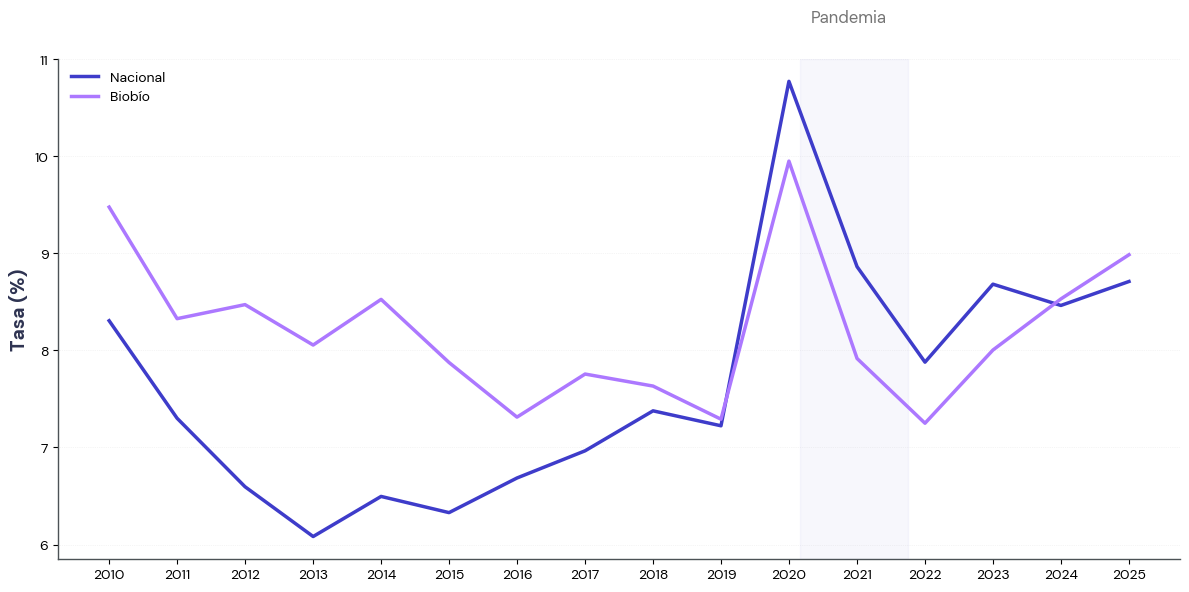

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
from pathlib import Path

# ‚îÄ‚îÄ‚îÄ Configurar fuente DM Sans ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
FONT_PATHS = ["/content/drive/MyDrive/Data/fonts/"]
FONT_FILES = ["DMSans-Regular.ttf", "DMSans-Bold.ttf", "DMSans-Italic.ttf"]
found_fonts = []
for base_path in FONT_PATHS:
    for font_file in FONT_FILES:
        font_path = Path(base_path) / font_file
        if font_path.exists():
            fm.fontManager.addfont(str(font_path))
            found_fonts.append(font_path)

dm_font_name = fm.FontProperties(fname=str(found_fonts[0])).get_name()
dm_font_props = fm.FontProperties(family=dm_font_name)
dm_font_bold  = fm.FontProperties(family=dm_font_name, weight="bold")

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': [dm_font_name, 'DejaVu Sans']
})



# ‚îÄ‚îÄ‚îÄ Paleta de colores ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
PALETTE = [
    "#4c5256", "#2e3351", "#161233", "#3e3cca",  # azul institucional
    "#c0c8eb", "#798dbf", "#ac78ff", "#48aee8",  # otros tonos
]

# ‚îÄ‚îÄ‚îÄ Cargar datos ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
ruta = "/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx"
df = pd.read_excel(ruta, sheet_name="panel_data")
df["Fecha"] = pd.to_datetime(df["Fecha"])

# ‚îÄ‚îÄ‚îÄ Filtrar Nacional y Biob√≠o ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
df_nac = df[df["region_name"] == "Nacional"]
df_bio = df[df["region_name"] == "Biob√≠o"]



# ‚îÄ‚îÄ‚îÄ Calcular promedio anual ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
df_nac_anual = df_nac.groupby("A√±o")["T_TDO_indicadoresprincipales"].mean().reset_index()
df_bio_anual = df_bio.groupby("A√±o")["T_TDO_indicadoresprincipales"].mean().reset_index()

# ‚îÄ‚îÄ‚îÄ Convertir a√±o a fecha para usar eje temporal ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
df_nac_anual["Fecha"] = pd.to_datetime(df_nac_anual["A√±o"].astype(str) + "-01-01")
df_bio_anual["Fecha"] = pd.to_datetime(df_bio_anual["A√±o"].astype(str) + "-01-01")

import matplotlib.dates as mdates
from matplotlib.dates import date2num

# ‚îÄ‚îÄ‚îÄ Crear gr√°fico ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# ‚îÄ‚îÄ‚îÄ Crear gr√°fico con fechas como eje ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
fig, ax = plt.subplots(figsize=(12, 6))

# Sombreado leve para pandemia
ax.axvspan(
    date2num(pd.to_datetime("2020-03-01")),
    date2num(pd.to_datetime("2021-10-01")),
    color="#3e3cca", alpha=0.04, zorder=0
)

# L√≠neas de promedio anual
ax.plot(df_nac_anual["Fecha"], df_nac_anual["T_TDO_indicadoresprincipales"],
        label="Nacional", color=PALETTE[3], linewidth=2.5)
ax.plot(df_bio_anual["Fecha"], df_bio_anual["T_TDO_indicadoresprincipales"],
        label="Biob√≠o", color=PALETTE[6], linewidth=2.5)

# Texto ‚ÄúPandemia‚Äù
ax.text(
    pd.to_datetime("2020-11-15"),
    ax.get_ylim()[1] * 1.03,
    "Pandemia",
    fontproperties=dm_font,
    fontsize=12,
    ha="center",
    va="bottom",
    color="#666666",
    alpha=0.9
)

# Ejes y formato
ax.set_ylabel("Tasa (%)", fontproperties=dm_font_bold, fontsize=14, color=PALETTE[1])

ax.set_xlabel("")
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=11)

for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(dm_font)

ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)

for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color(PALETTE[0])
ax.spines["bottom"].set_color(PALETTE[0])
ax.spines["left"].set_linewidth(1)
ax.spines["bottom"].set_linewidth(1)

ax.legend(frameon=False, loc="upper left", fontsize=12, prop=dm_font)

plt.tight_layout()
plt.show()



In [ ]:
# ‚îÄ‚îÄ‚îÄ 1. Configuraci√≥n inicial ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from pathlib import Path

# Paleta institucional
PALETTE = [
    "#4c5256", "#2e3351", "#161233", "#3e3cca",
    "#c0c8eb", "#798dbf", "#ac78ff", "#48aee8",
]

# Paths
FONT_PATHS = ["/content/drive/MyDrive/Data/fonts/"]
PANEL_PATH = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx")
OUT_FILE   = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/variacion_tdo.png")

# ‚îÄ‚îÄ‚îÄ 2. Cargar fuentes DM Sans desde Drive ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
FONT_FILES = ["DMSans-Regular.ttf", "DMSans-Bold.ttf", "DMSans-Italic.ttf"]
found_fonts = []
for base_path in FONT_PATHS:
    for font_file in FONT_FILES:
        font_path = Path(base_path) / font_file
        if font_path.exists():
            fm.fontManager.addfont(str(font_path))
            found_fonts.append(font_path)

dm_font_name = fm.FontProperties(fname=str(found_fonts[0])).get_name()
dm_font_props = fm.FontProperties(family=dm_font_name)
dm_font_bold  = fm.FontProperties(family=dm_font_name, weight="bold")

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': [dm_font_name, 'DejaVu Sans']
})

# ‚îÄ‚îÄ‚îÄ 3. Cargar datos y calcular promedio anual ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
df = pd.read_excel(PANEL_PATH, sheet_name="biobio_vs_nacional")
df["Fecha"] = pd.to_datetime(df["Fecha"])
df["A√±o"] = df["Fecha"].dt.year

prom = df.groupby(["A√±o", "region_name"])["T_TDO_indicadoresprincipales"].mean().unstack()
prom = prom[prom.index >= 2010]  # Puedes ajustar este filtro

# ‚îÄ‚îÄ‚îÄ 4. Gr√°fico de barras ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
x = np.arange(len(prom.index))

# Barras
ax.bar(x - bar_width/2, prom["Nacional"], width=bar_width,
       color=PALETTE[3], label="Nacional")
ax.bar(x + bar_width/2, prom["Biob√≠o"], width=bar_width,
       color=PALETTE[6], label="Biob√≠o")

# Eje X
ax.set_xticks(x)
ax.set_xticklabels(prom.index, fontproperties=dm_font_props, fontsize=12)

# Eje Y
ax.set_ylabel("Tasa (%)",
              fontproperties=dm_font_bold, fontsize=14, color=PALETTE[1])
ax.tick_params(axis='y', labelsize=11)
for label in ax.get_yticklabels():
    label.set_fontproperties(dm_font_props)

# L√≠nea cero y rejilla
ax.axhline(0, color=PALETTE[0], linestyle="--", linewidth=1, alpha=0.4)
ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.25)
ax.xaxis.grid(False)

# Sombreado pandemia
x_dict = {a√±o: i for i, a√±o in enumerate(prom.index)}
if 2020 in x_dict and 2021 in x_dict:
    ax.axvspan(x_dict[2020] - 0.5, x_dict[2021] + 0.5,
               color=PALETTE[3], alpha=0.05, zorder=0)
    x_centro = (x_dict[2020] + x_dict[2021]) / 2  # ‚Üê Definir aqu√≠

# Layout antes de insertar texto para conocer los l√≠mites
plt.tight_layout()
plt.draw()

# 1. Subimos l√≠mite del eje Y con margen c√≥modo
y_max = prom.max().max() + 1.6
ax.set_ylim(0, y_max)

# 2. Texto ‚ÄúPandemia‚Äù m√°s arriba, sin superposici√≥n
ax.text(x_centro, y_max * 0.97,
        "Pandemia", ha="center", va="top",
        fontsize=11, fontproperties=dm_font_props,
        color=PALETTE[0], alpha=0.6)

# 3. Etiquetas sobre barras, m√°s espaciadas
for i, a√±o in enumerate(prom.index):
    nac_val = prom.loc[a√±o, "Nacional"]
    bio_val = prom.loc[a√±o, "Biob√≠o"]

    ax.text(x[i] - bar_width/2, nac_val + 0.15, f"{nac_val:.1f}",
            ha="center", fontsize=8, fontproperties=dm_font_props,
            color=PALETTE[3])

    ax.text(x[i] + bar_width/2, bio_val + 0.15, f"{bio_val:.1f}",
            ha="center", fontsize=8, fontproperties=dm_font_props,
            color=PALETTE[6])

# Leyenda
ax.legend(frameon=False, loc="upper right",
          prop=dm_font_props, fontsize=12)

# Bordes
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["left"].set_color(PALETTE[0])
ax.spines["bottom"].set_color(PALETTE[0])

# Mostrar y guardar
plt.show()

try:
    OUT_FILE.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(OUT_FILE, dpi=300, bbox_inches='tight',
                facecolor='white', edgecolor='none')
    print(f"‚úÖ Gr√°fico guardado: {OUT_FILE}")
except Exception as e:
    print(f"‚ö†Ô∏è Error al guardar: {e}")


‚úÖ Gr√°fico guardado: /content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/variacion_tdo.png


<Figure size 640x480 with 0 Axes>

# Mapas de calor


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


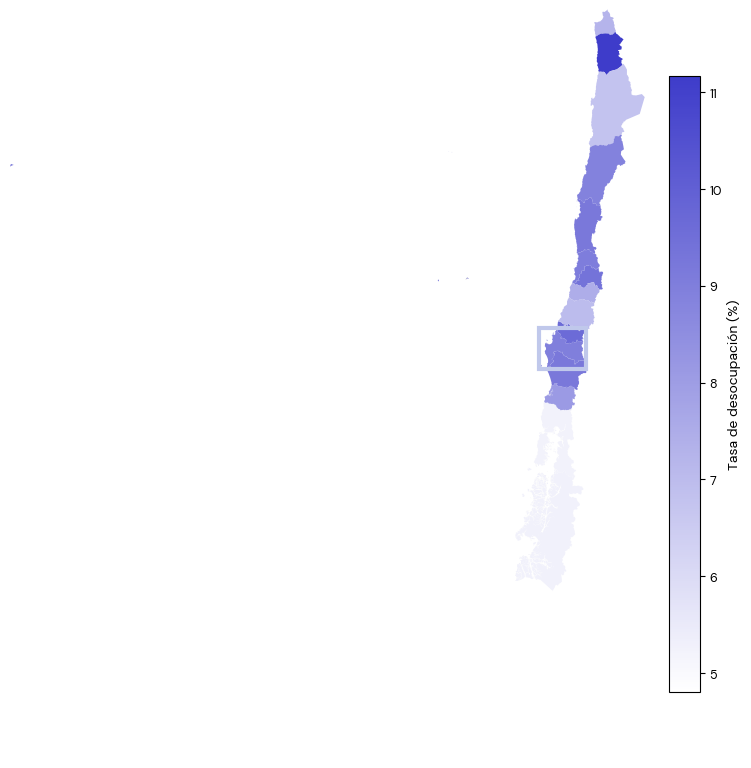

In [212]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from pathlib import Path
import numpy as np
import matplotlib.font_manager as fm

# ‚îÄ‚îÄ‚îÄ 1. Cargar shapefile y datos ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
shp_path = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/shp_regiones/Regional.shp")
xls_path = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx")

gdf = gpd.read_file(shp_path)
df = pd.read_excel(xls_path, sheet_name='panel_data')
df = df[(df['Periodo'] == '2025Q1') & (~df['region_name'].isin(['Nacional']))]

# ‚îÄ‚îÄ‚îÄ 2. Limpieza de nombres ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
def quitar_comillas(s):
    if isinstance(s, str):
        return s.replace("'", "").replace("‚Äô", "").replace("‚Äò", "").replace("`", "").strip()
    return s

df['region_name'] = df['region_name'].apply(quitar_comillas)
gdf['Region'] = gdf['Region'].apply(quitar_comillas)

mapeo = {
    'Antofagasta': 'Regi√≥n de Antofagasta',
    'Araucan√≠a': 'Regi√≥n de La Araucan√≠a',
    'Arica y Parinacota': 'Regi√≥n de Arica y Parinacota',
    'Atacama': 'Regi√≥n de Atacama',
    'Ays√©n': 'Regi√≥n de Ays√©n del Gral.Iba√±ez del Campo',
    'Biob√≠o': 'Regi√≥n del B√≠o-B√≠o',
    'Coquimbo': 'Regi√≥n de Coquimbo',
    'Los Lagos': 'Regi√≥n de Los Lagos',
    'Los R√≠os': 'Regi√≥n de Los R√≠os',
    'Magallanes': 'Regi√≥n de Magallanes y Ant√°rtica Chilena',
    'Maule': 'Regi√≥n del Maule',
    'OHiggins': 'Regi√≥n del Libertador Bernardo OHiggins',
    'Regi√≥n Metropolitana': 'Regi√≥n Metropolitana de Santiago',
    'Tarapac√°': 'Regi√≥n de Tarapac√°',
    'Valpara√≠so': 'Regi√≥n de Valpara√≠so',
    '√ëuble': 'Regi√≥n de √ëuble'
}
df['region_shp'] = df['region_name'].map(mapeo)

# ‚îÄ‚îÄ‚îÄ 3. Merge con datos y c√°lculo de tasas ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
df_grouped = df.groupby('region_shp')['T_TDO_indicadoresprincipales'].mean().reset_index(name='tasa_desocupacion')
gdf = gdf.merge(df_grouped, left_on='Region', right_on='region_shp', how='left')
gdf = gdf[gdf['Region'] != 'Zona sin demarcar']

# ‚îÄ‚îÄ‚îÄ 4. Paleta institucional azul ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
cmap = LinearSegmentedColormap.from_list("degrade_continuo", ["#ffffff", "#3e3cca"], N=256)

# ‚îÄ‚îÄ‚îÄ 5. Figura principal ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
fig, ax = plt.subplots(figsize=(10, 20))
gdf.plot(
    column='tasa_desocupacion',
    cmap=cmap,
    linewidth=0,
    edgecolor='none',
    ax=ax,
    legend=False,
    vmin=gdf['tasa_desocupacion'].min(),
    vmax=gdf['tasa_desocupacion'].max(),
    missing_kwds={"color": "#e8e8e8"}
)

# Forzar a mostrar TODO el pa√≠s
ax.set_xlim(gdf.total_bounds[0], gdf.total_bounds[2])
ax.set_ylim(gdf.total_bounds[1], gdf.total_bounds[3])
ax.set_axis_off()

# ‚îÄ‚îÄ‚îÄ 6. Cuadro sobre Biob√≠o ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
try:
    row_bio = gdf[gdf['region_shp'] == 'Regi√≥n del B√≠o-B√≠o'].iloc[0]
    bounds = row_bio.geometry.bounds
    x_center = (bounds[0] + bounds[2]) / 2
    y_center = (bounds[1] + bounds[3]) / 2
    width = (bounds[2] - bounds[0]) * 1.05
    height = (bounds[3] - bounds[1]) * 1.05
    ax.add_patch(Rectangle(
        (x_center - width/2, y_center - height/2),
        width, height,
        facecolor='none',
        edgecolor='#C0C8EB',
        linewidth=3,
        zorder=5
    ))
except:
    print("‚ö† No se encontr√≥ Biob√≠o para destacar")

# ‚îÄ‚îÄ‚îÄ 7. Barra de color integrada ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
norm = mcolors.Normalize(vmin=gdf['tasa_desocupacion'].min(), vmax=gdf['tasa_desocupacion'].max())
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []

cbar = fig.colorbar(sm, ax=ax, shrink=0.4, pad=0.02)
cbar.set_label("Tasa de desocupaci√≥n (%)", fontsize=10)
cbar.ax.tick_params(labelsize=9)

# ‚îÄ‚îÄ‚îÄ 8. Guardar como PNG limpio ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
plt.savefig("mapa_desocupacion_chile_q1_2025.png", dpi=300, bbox_inches='tight')
plt.show()


In [214]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle
from pathlib import Path
import matplotlib.font_manager as fm
import numpy as np

# ‚îÄ‚îÄ‚îÄ 1. Rutas y carga ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
shp_path = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/shp_regiones/Regional.shp")
xls_path = Path("/content/drive/MyDrive/Data/Mercado_Laboral/Biobio/resultados/panel_ENE_unificado.xlsx")

gdf = gpd.read_file(shp_path)
df = pd.read_excel(xls_path, sheet_name='panel_data')
df = df[(df['Periodo'] == '2025Q1') & (~df['region_name'].isin(['Nacional']))]

# ‚îÄ‚îÄ‚îÄ 2. Eliminar comillas para asegurar match de nombres ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
def quitar_comillas(s):
    if isinstance(s, str):
        return s.replace("'", "").replace("‚Äô", "").replace("‚Äò", "").replace("`", "").strip()
    return s

df['region_name'] = df['region_name'].apply(quitar_comillas)
gdf['Region'] = gdf['Region'].apply(quitar_comillas)


# ‚îÄ‚îÄ‚îÄ 3. Verificar nombres √∫nicos y crear mapeo ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
print("Regiones en el shapefile:")
print(gdf['Region'].unique())
print(f"\nTotal regiones en shapefile: {len(gdf['Region'].unique())}")

print("\nRegiones en los datos:")
print(df['region_name'].unique())
print(f"\nTotal regiones en datos: {len(df['region_name'].unique())}")

# Diccionario de mapeo actualizado
mapeo = {
    'Antofagasta': 'Regi√≥n de Antofagasta',
    'Araucan√≠a': 'Regi√≥n de La Araucan√≠a',
    'Arica y Parinacota': 'Regi√≥n de Arica y Parinacota',
    'Atacama': 'Regi√≥n de Atacama',
    'Ays√©n': 'Regi√≥n de Ays√©n del Gral.Iba√±ez del Campo',
    'Biob√≠o': 'Regi√≥n del B√≠o-B√≠o',
    'Coquimbo': 'Regi√≥n de Coquimbo',
    'Los Lagos': 'Regi√≥n de Los Lagos',
    'Los R√≠os': 'Regi√≥n de Los R√≠os',
    'Magallanes': 'Regi√≥n de Magallanes y Ant√°rtica Chilena',
    'Maule': 'Regi√≥n del Maule',
    'OHiggins': 'Regi√≥n del Libertador Bernardo OHiggins',
    'Regi√≥n Metropolitana': 'Regi√≥n Metropolitana de Santiago',
    'Tarapac√°': 'Regi√≥n de Tarapac√°',
    'Valpara√≠so': 'Regi√≥n de Valpara√≠so',
    '√ëuble': 'Regi√≥n de √ëuble'
}

df['region_shp'] = df['region_name'].map(mapeo)

# Verificar el mapeo despu√©s de la limpieza
print("\nDespu√©s de la limpieza:")
print("Nombres √∫nicos en los datos:")
print(df['region_name'].unique())

# Verificar el mapeo
print("\nVerificaci√≥n del mapeo:")
print("Regiones no mapeadas en los datos:")
no_mapeadas = df[df['region_shp'].isna()]['region_name'].unique()
print(no_mapeadas)

print("\nRegiones del shapefile sin datos:")
df_grouped = df.groupby('region_shp')['T_TDO_indicadoresprincipales'].mean().reset_index(name='tasa_desocupacion')
regiones_con_datos = set(df_grouped['region_shp'].unique())
regiones_shp = set(gdf['Region'].unique())
sin_datos = regiones_shp - regiones_con_datos
print(sin_datos)

gdf = gdf.merge(df_grouped, left_on='Region', right_on='region_shp', how='left')

# Eliminar "Zona sin demarcar" del GeoDataFrame
gdf = gdf[gdf['Region'] != 'Zona sin demarcar']

print(f"\nZona sin demarcar eliminada del mapa")

# Mostrar regiones con valores faltantes
print(f"\nRegiones con datos faltantes en el mapa final:")
regiones_na = gdf[gdf['tasa_desocupacion'].isna()]['Region'].tolist()
print(regiones_na)

# ‚îÄ‚îÄ‚îÄ 4. Cargar fuente DM Sans (opcional) ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
try:
    font_path = "/content/drive/MyDrive/Data/fonts/DMSans-Regular.ttf"
    fm.fontManager.addfont(font_path)
    dm_font = fm.FontProperties(fname=font_path)
except:
    dm_font = None

# ‚îÄ‚îÄ‚îÄ 5. Paleta continua: blanco a azul institucional ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
cmap = LinearSegmentedColormap.from_list("degrade_continuo", [
    "#ffffff",  # claro para valores bajos
    "#3e3cca"   # azul institucional para valores altos
], N=256)

# ‚îÄ‚îÄ‚îÄ 6. Crear figura simple ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
fig, ax_map = plt.subplots(figsize=(12, 16))

# Crear el mapa
im = gdf.plot(
    column='tasa_desocupacion',
    cmap=cmap,
    linewidth=0.2,
    edgecolor='white',
    ax=ax_map,
    legend=False,
    vmin=gdf['tasa_desocupacion'].min(),
    vmax=gdf['tasa_desocupacion'].max(),
    missing_kwds={"color": "#e8e8e8", "edgecolor": "white", "linewidth": 0.8}
)

# ‚îÄ‚îÄ‚îÄ 7. A√±adir rect√°ngulo sobre el Biob√≠o ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
try:
    row_bio = gdf[gdf['region_shp'] == 'Regi√≥n del B√≠o-B√≠o'].iloc[0]
    bounds = row_bio.geometry.bounds
    x_center = (bounds[0] + bounds[2]) / 2
    y_center = (bounds[1] + bounds[3]) / 2
    width = (bounds[2] - bounds[0]) * 1.1
    height = (bounds[3] - bounds[1]) * 1.1

    ax_map.add_patch(Rectangle(
        (x_center - width/2, y_center - height/2), width, height,
        facecolor='none',
        edgecolor='#C0C8EB',
        linewidth=3,
        zorder=5
    ))
except:
    print("No se pudo encontrar la regi√≥n del Biob√≠o")

# ‚îÄ‚îÄ‚îÄ 8. Crear barra minimalista y compacta ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# Calcular rangos
min_val = gdf['tasa_desocupacion'].min()
max_val = gdf['tasa_desocupacion'].max()

# Posici√≥n de la barra - m√°s peque√±a y centrada
bar_x = 1.2     # posici√≥n horizontal
bar_y = 0.4       # centrada verticalmente
bar_width = 0.02  # m√°s delgada
bar_height = 0.25 # solo 25% del alto total (minimalista)

# Crear la barra gradiente compacta
bar_ax = fig.add_axes([bar_x, bar_y, bar_width, bar_height])
gradient = np.linspace(0, 1, 256).reshape(256, -1)
bar_ax.imshow(gradient, aspect='auto', cmap=cmap, extent=[0, 1, min_val, max_val])

# Configurar la barra
bar_ax.set_xlim(0, 1)
bar_ax.set_ylim(min_val, max_val)
bar_ax.set_xticks([])

# Solo 3 etiquetas (m√≠nimo, medio, m√°ximo) - s√∫per minimalista
tick_values = [min_val, (min_val + max_val) / 2, max_val]
tick_labels = [f'{val:.1f}%' for val in tick_values]

bar_ax.set_yticks(tick_values)
bar_ax.set_yticklabels(tick_labels, fontsize=9,
                       fontproperties=dm_font if dm_font else None)
bar_ax.tick_params(axis='y', length=0, pad=8)

# Quitar todos los bordes
for spine in bar_ax.spines.values():
    spine.set_visible(False)

# ‚îÄ‚îÄ‚îÄ 9. Configurar mapa principal ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
ax_map.set_axis_off()

# Ajustar layout
plt.tight_layout()
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

plt.show()

# ‚îÄ‚îÄ‚îÄ 10. Informaci√≥n adicional para debugging ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
print(f"\nRango de valores: {min_val:.2f}% - {max_val:.2f}%")
print(f"N√∫mero de regiones con datos: {gdf['tasa_desocupacion'].notna().sum()}")
print(f"N√∫mero total de regiones: {len(gdf)}")

Regiones en el shapefile:
['Regi√≥n de Arica y Parinacota' 'Regi√≥n de Tarapac√°'
 'Regi√≥n de Antofagasta' 'Regi√≥n de Magallanes y Ant√°rtica Chilena'
 'Regi√≥n de Ays√©n del Gral.Iba√±ez del Campo' 'Regi√≥n de Atacama'
 'Regi√≥n de Coquimbo' 'Regi√≥n de Valpara√≠so'
 'Regi√≥n Metropolitana de Santiago' 'Regi√≥n de Los Lagos'
 'Regi√≥n de Los R√≠os' 'Regi√≥n de La Araucan√≠a' 'Regi√≥n del B√≠o-B√≠o'
 'Regi√≥n de √ëuble' 'Regi√≥n del Maule'
 'Regi√≥n del Libertador Bernardo OHiggins' 'Zona sin demarcar']

Total regiones en shapefile: 17

Regiones en los datos:
['Ays√©n' 'Antofagasta' 'Arica y Parinacota' 'Araucan√≠a' 'Atacama' 'Biob√≠o'
 'Coquimbo' 'OHiggins' 'Los Lagos' 'Los R√≠os' 'Magallanes' 'Maule' '√ëuble'
 'Regi√≥n Metropolitana' 'Tarapac√°' 'Valpara√≠so']

Total regiones en datos: 16

Despu√©s de la limpieza:
Nombres √∫nicos en los datos:
['Ays√©n' 'Antofagasta' 'Arica y Parinacota' 'Araucan√≠a' 'Atacama' 'Biob√≠o'
 'Coquimbo' 'OHiggins' 'Los Lagos' 'Los R√≠os' 'Magallanes' 'M

<ipython-input-214-2833140362>:176: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



Rango de valores: 4.81% - 11.17%
N√∫mero de regiones con datos: 16
N√∫mero total de regiones: 16
